# M-Lab Data Analysis Notebook

An autonomous system number (ASN) is a unique number assigned to an autonomous system(AS) by the Internet Assigned Numbers Authority (IANA).

An AS consists of blocks of IP addresses which have a distinctly defined policy for accessing external networks and are administered by a single organization but may be made up of several operators.

IPs of Starlink User Terminals have the ASN of `14593`

Also see:
- https://www.peeringdb.com/net/18747
- https://www.measurementlab.net/data/


In [1]:
from matplotlib import font_manager
font_manager_list = font_manager.fontManager

In [2]:
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geohash
import cartopy.crs as ccrs
from datetime import datetime
import geohash
import geopandas
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
from matplotlib import colors
from descartes import PolygonPatch
from unidecode import unidecode
from matplotlib.patches import Patch

# Setting global font to "CMU Sans Serif"
from matplotlib import rcParams
rcParams["font.family"] = "CMU Sans Serif"

# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)

I currently am using the [BigQuery interface](https://console.cloud.google.com/bigquery?project=measurement-lab&pli=1) to get the M-Lab data. The query result are then downloaded to the `./data/mlab_starlink_data` folder as a .csv file and used by the following scripts. The `./data/mlab_starlink_data/README.md` stores the used queries.

---

**Why not use the API?**

Because of this ([source](https://www.measurementlab.net/data/docs/bq/quickstart/)):

> [...] Because of the means by which M-Lab must whitelist query users, we cannot guarantee that no charges will be incurred by applications using service accounts which query M-Lab datasets, tables, and views.

**Retrieving the mlab data**

execute this to retrieve the data

```bash
cd /path/to/this/notebook
cd data
wget https://syncandshare.lrz.de/dl/fiXT6TrDAYGGsK6To7v75K/mlab_starlink_data.zip
unzip mlab_starlink_data.zip
```

### Retrieving Pandas Dataframes used in this Analysis

In [3]:
# Retrieving Datasets as dataframes
ndt7_df   = pd.read_csv("./data/mlab_starlink_data/ndt7_cities_overview.csv").set_index("ClientGeohash")
ndt7_df = ndt7_df.sort_values(by="MeasurementCount", ascending=False)
ndt7_df["lat"] = [geohash.decode(gh)[0] for gh in ndt7_df.index]
ndt7_df["lon"] = [geohash.decode(gh)[1] for gh in ndt7_df.index]

In this dataset, we have hashed the IP geolocated probe data with geohash of length 5 which corresponds to 2.4km. Converting back to lat/lon coordinates, we would have an accuracy of 2.4km

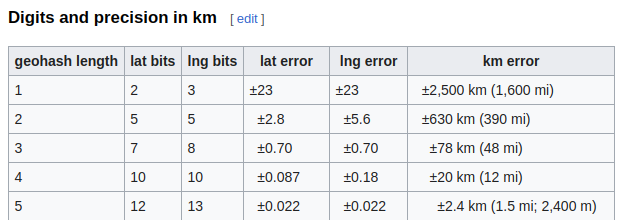

In [4]:
ndt7_df[["ClientCountry", "lat", "lon", "MeasurementCount"]].to_csv("temp.csv")

In [6]:
asdasd_df = ndt7_df.dropna(subset = "ClientCity")["ClientCity"].drop_duplicates()
sl_city_filter = "AND (\n{}\n)".format(" OR\n".join("\t(client.Geo.City = \"{}\")".format(city) for city in asdasd_df.values))
# TODO: ClientCity, ClientCountry, server_site, server country code, server geo city
print(sl_city_filter)

AND (
	(client.Geo.City = "Seattle") OR
	(client.Geo.City = "Chicago") OR
	(client.Geo.City = "Atlanta") OR
	(client.Geo.City = "Los Angeles") OR
	(client.Geo.City = "New York") OR
	(client.Geo.City = "Sydney") OR
	(client.Geo.City = "Toronto") OR
	(client.Geo.City = "Denver") OR
	(client.Geo.City = "Dallas") OR
	(client.Geo.City = "London") OR
	(client.Geo.City = "Mexico City") OR
	(client.Geo.City = "Berlin") OR
	(client.Geo.City = "São Paulo") OR
	(client.Geo.City = "Calgary") OR
	(client.Geo.City = "Vancouver") OR
	(client.Geo.City = "Auckland") OR
	(client.Geo.City = "Winnipeg") OR
	(client.Geo.City = "Montreal") OR
	(client.Geo.City = "Rome") OR
	(client.Geo.City = "Paris") OR
	(client.Geo.City = "Santiago") OR
	(client.Geo.City = "Dublin") OR
	(client.Geo.City = "Madrid") OR
	(client.Geo.City = "Lagos") OR
	(client.Geo.City = "Brussels") OR
	(client.Geo.City = "Lisbon") OR
	(client.Geo.City = "Vienna") OR
	(client.Geo.City = "Tokyo") OR
	(client.Geo.City = "Bogotá") OR
	(client.

In [284]:
mlab_data_path = "./data/mlab_starlink_data"
csvs = [
    "/ndt7_city_filtered1.csv",
    "/ndt7_city_filtered2.csv",
    "/ndt7_city_filtered3.csv",
    "/ndt7_city_filtered4.csv",
    "/ndt7_city_filtered5.csv",
    "/ndt7_city_filtered6.csv",
    "/ndt7_city_filtered7.csv",
    "/ndt7_city_filtered8.csv"
]
city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])

def convert_date(datestr):
    try:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S.%f %Z')
    except ValueError:
        return datetime.strptime(datestr, '%Y-%m-%d %H:%M:%S %Z')
city_df["a_TestTime"]  = city_df["a_TestTime"].apply(convert_date)
city_df["a_TestMonth"] = city_df["a_TestTime"].apply(lambda date: datetime(year=date.year, month=date.month, day = 1))
city_df["a_DiffRTT"] = city_df["a_MaxRTT"] - city_df["a_MinRTT"]

city_df = city_df[city_df["a_MinRTT"] < 2000] # Discarding outliers. Arbitrary chosen limit of 2000 ms

/tmp/ipykernel_1674590/2321015131.py:12: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])
/tmp/ipykernel_1674590/2321015131.py:12: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  city_df = pd.concat([pd.read_csv(mlab_data_path + csvpath) for csvpath in csvs])


In [8]:
city_df["a_DiffRTT"] = city_df["a_MaxRTT"] - city_df["a_MinRTT"]

In [342]:
from unidecode import unidecode

# Self defined region
def filter_na(ddf, linktype="down"):
    lon_bound = (-130, -63.6)
    lat_bound = (25, 52)
    
    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_City"].map(unidecode) == ddf["server_Geo_City"].map(unidecode)]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
    
    return ddf

def filter_sa(ddf, linktype="down"):
    lon_bound = (-90, -34)
    lat_bound = (-57.46, 12)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_CountryCode"] == ddf["server_Geo_CountryCode"]]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_eu(ddf, linktype="down"):
    lon_bound = (-13, 40)
    lat_bound = (35, 72)
    
    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[ddf["client_Geo_CountryCode"] == ddf["server_Geo_CountryCode"]]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_au(ddf, linktype="down"):
    lon_bound = (110, 180)
    lat_bound = (-48.2, -10)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    ddf = ddf[((ddf["server_Geo_City"].map(unidecode) == "Sydney") & (ddf["client_Geo_CountryCode"].map(unidecode) == "AU")) | (ddf["client_Geo_CountryCode"].map(unidecode) == ddf["server_Geo_CountryCode"].map(unidecode))]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

def filter_mx(ddf, linktype="down"):
    lon_bound = (-118.2,-50)
    lat_bound = (8.3, 28)

    ddf = ddf[
            ((ddf["client_Geo_Latitude"] > lat_bound[0]) & (ddf["client_Geo_Latitude"] < lat_bound[1])) &
            ((ddf["client_Geo_Longitude"] > lon_bound[0]) & (ddf["client_Geo_Longitude"] < lon_bound[1]))
        ]
    if linktype == "down":
        ddf = ddf[ddf["isDownload"] == True]
    elif linktype == "up":
        ddf = ddf[ddf["isDownload"] == False]
        
    return ddf

region_filters = {
    "NA": filter_na,
    "SA": filter_sa,
    "EU": filter_eu,
    "AU": filter_au,
    "MX": filter_mx
}

In [11]:
# Retrieving Starlink Availability scraped from wikipedia
from bs4 import BeautifulSoup
import requests

response = requests.get("https://en.wikipedia.org/wiki/Starlink")
soup = BeautifulSoup(response.text)

countries_soup = soup.find_all("table", attrs={"class": "wikitable"})[1]

countries = []
for a in countries_soup.find_all("tr")[1:]:
    for b in a.find_all("td")[2].find_all("a"):
        countries.append(b.text)
countries.sort()
countries.remove("Czech Republic")
countries.append("Czechia")
countries.remove("United States Virgin Islands")
countries.append("U.S. Virgin Islands")

In [12]:
# Loading RIPE Atlas Probe location
from io import StringIO
ripe_loc_df = pd.read_csv(StringIO("""
place,country_code,latitude,longitude
Mifflinville,US,41.0585,-76.3415
Aldeno,IT,45.9815,11.1005
Friday Harbor,US,48.4785,-122.8605
Maisach,DE,48.2215,11.2575
Pahrump,US,36.2115,-115.9785
Firestone,US,40.1095,-104.9415
Kitzingen,DE,49.7285,10.1485
London,GB,51.5105,-0.1295
York Harbor,US,43.1575,-70.6485
Kettle Falls,US,48.4315,-118.1695
Oneida,US,44.5405,-88.2525
Goldendale,US,45.8415,-120.7095
Fuerstenfeldbruck,DE,48.2015,11.2415
Lalendorf,DE,53.7475,12.3395
Sydney,AU,-33.8715,151.1995
Gambolo,IT,45.2505,8.8605
Greenville,US,40.1205,-120.9015
Woodland,US,45.8985,-122.7395
Lauder,GB,55.6815,-2.7895
Rathdrum,US,47.8115,-116.9005
Millgrove,AU,-37.8315,145.6815
Golden,US,39.7485,-105.2225
Barview,US,43.2505,-124.3915
Henderson,US,35.9515,-115.0215
Nackawic,CA,45.8985,-67.0305
Stattegg,AT,47.1375,15.4515
Berryville,US,39.1005,-77.9625
Brooklyn,US,42.8485,-89.3715
Tairua,NZ,-37.0105,175.8595
De Queen,US,34.2875,-94.2715
Wetaskiwin,CA,53.1285,-113.2085
Scotts Valley,US,37.0415,-121.9915
Beaufort,US,34.7175,-76.6585
Limeil-Brevannes,FR,48.7475,2.4895
Neosho,US,36.8495,-94.3795
Retiro,ES,40.4215,-3.6885
Chicago,US,41.8875,-87.6315
Spencer,US,39.2115,-86.8685
Black Canyon City,US,34.0795,-112.1295
Winlock,US,46.5015,-122.9685
Superior,US,39.9975,-105.2105
Fronton,FR,43.8485,1.3995
Kanwal,AU,-33.2605,151.4785
Durango,US,37.2075,-107.9815
Louvain-la-Neuve,BE,50.6675,4.6185
Zaandam,NL,52.4415,4.8315
Seyne-les-Alpes,FR,44.4075,6.4495
Czarna Woda,PL,53.8295,18.0395
Klagenfurt am Woerthersee,AT,46.6395,14.2915
Limache,CL,-33.0105,-71.2615
Arnprior,CA,45.4575,-76.2025
Butte,US,61.5685,-149.0125
Othello,US,46.7585,-119.1685
Hillsborough,US,36.1185,-79.1605
Sidney,US,40.8585,-102.8625
Nimes,FR,43.8315,4.3215
"""))

### Color / Style Definitions Scheme

In [13]:
continents = ["AF", "AS", "EU", "NA", "OC", "SA"]
cols = plt.get_cmap("tab10").colors
lstyle_array = ["solid", "dotted", "dashed", "dashdot"]

### Helper Functions

In [382]:
a = [(i, c) for i, c in enumerate(continents)]

In [383]:
a

[(0, 'AF'), (1, 'AS'), (2, 'EU'), (3, 'NA'), (4, 'OC'), (5, 'SA')]

In [385]:
b = sorted(a, key=(lambda t: t[1]), reverse=False)
b

[(0, 'AF'), (1, 'AS'), (2, 'EU'), (3, 'NA'), (4, 'OC'), (5, 'SA')]

In [513]:
import os
def plot_cdf(df, cities, column, xlabel,
                 ax=None,
                 fig=None,
                 show=True,
                 figsize=(7, 4),
                 savefig="",
                 title="CDF",
                 city_colors={},
                 lstyles={},
                 condition=True,
                 skiplegend=False,
                 figures_path="figures", xlim=None, legendsettings={}, legendloc="lower right", xticks=None, xticklabels=None, ylabel="Percentile", stripylabels=False):
    if ax==None:
        fig, ax = plt.subplots(figsize=figsize)
    for city in cities:
        #  & (df["a_MinRTT"] < 600)
        xs = df[(df["client_Geo_City"] == city) & (condition)][column].values
        xs = sorted(xs)
        if len(xs) == 0:
            print(city)
            raise RuntimeError()
        ys = np.arange(1, len(xs) + 1) / len(xs)
        indices = []
        current = xs[0]
        for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
            if x != current:
                current = x
                indices.append(i - 1)
        indices.append(len(ys) - 1)
        xs = sorted(set(xs))
        ys = [ys[i] for i in indices]
        ax.plot(xs, ys, label=city, color=city_colors[city], linestyle=lstyles[city])

    if xlim is not None:
        ax.set_xlim(*xlim)
    if xticks is not None:
        ax.set_xticks(xticks)
    if xticklabels is not None:
        ax.set_xticks(xticklabels)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if stripylabels:
        ax.set_yticks(np.arange(0, 1.25, 0.25), labels=[""]*len(np.arange(0, 1.25, 0.25)))
    else:
        ax.set_yticks(np.arange(0, 1.25, 0.25))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    handles, labels = plt.gca().get_legend_handles_labels()
    sorted_hl = sorted(zip(handles, labels), key=(lambda t: t[1]), reverse=False)
    if not skiplegend:
        ax.legend([t[0] for t in sorted_hl],
                  [t[1] for t in sorted_hl], loc=legendloc, fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)
    ax.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
    
    ax.set_ylim((-0.05, 1.05))

    #plt.title(title)
    if fig != None:
        fig.tight_layout()
    if(savefig != ""):
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    if show:
        plt.show()

In [15]:
def plot_probe_map(city_overview_df, city_df, interesting_cities,
                       lon_bounds = (-180, 180),
                       lat_bounds = (-90, 90),
                       figsize=(7, 6),
                       annotate = True,
                       annotate_minimal = False,
                       savefig = "",
                       figures_path="figures"):
    city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
    lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}
    
    client_country_coords_df = city_overview_df.groupby(["ClientCountry", "ClientCity"])[["lat", "lon"]].mean()
    client_country_coords_df = client_country_coords_df[(
                                    client_country_coords_df["lat"] > lat_bounds[0]) & (client_country_coords_df["lat"] < lat_bounds[1]
                                                        )]
    client_country_coords_df = client_country_coords_df[(
                                    client_country_coords_df["lon"] > lon_bounds[0]) & (client_country_coords_df["lon"] < lon_bounds[1]
                                                        )]

    world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
    world = world[(world.name!="Antarctica")]

    def plotCountryPatch( axes, country_name, fcolor ):
        # plot a country on the provided axes
        nami = world[world.name == country_name]
        namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
        namig0 = {'type': namigm[0]['geometry']['type'], \
                  'coordinates': namigm[0]['geometry']['coordinates']}
        axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.2, zorder=2, linewidth=0.0 ))


    fig, ax = plt.subplots(figsize=figsize, subplot_kw={'projection': ccrs.PlateCarree()})

    ax.set_xlim(lon_bounds)
    ax.set_ylim(lat_bounds)

    cmap = colors.ListedColormap(cols[:-2])
    world.plot(facecolor = "grey", edgecolor="black", ax=ax, linewidth=0.2, alpha=0.2, zorder=0)

    for c in countries:
        c = "United States of America" if c == "United States" else c
        c = "Czechia" if c == "Czech Republic" else c

        if(c in world["name"].values):
            plotCountryPatch(ax, c, "#364aa088")

    client_country_df = city_overview_df.groupby(["ClientCountry", "ClientCity"])[["lat", "lon"]].mean()
    latitude, longitude = client_country_coords_df["lat"], client_country_coords_df["lon"]
    ax.scatter(longitude, latitude, 
                   sizes = [0.7],
                   color="#a8290a88",
                   zorder = 10)

    # Filtered with interesting_cities
    client_country_df = city_overview_df[city_overview_df["ClientCity"].isin(interesting_cities)].groupby(["ClientCountry", "ClientCity"])[["lat", "lon"]].mean()
    latitude, longitude = client_country_df["lat"], client_country_df["lon"]
    ax.scatter(longitude, latitude, 
                   sizes = [10.1],
                   color="green",
                   zorder = 9, marker="x")

    for x, y, label in zip(client_country_coords_df["lon"], client_country_coords_df["lat"], client_country_coords_df.index):
        if(annotate and ((not annotate_minimal) or (label[1] in interesting_cities))):
            ax.annotate(label[1], xy=(x, y), xytext=(-7, 5), textcoords="offset points")

    plt.tight_layout()
    if(savefig != ""):
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    plt.show()

In [412]:
def plot_boxplot_progression(datetime_array, data_array,
                                savefig = "",
                                figsize=(7, 6),
                                ylabel = "",
                                figures_path="figures",
                                nlegendcols=3,
                                ylim=None,
                                xlim=None,
                                decimation=1,
                                orientation="upper right"):
    """
    Plot boxplot progression. As input you give a
    """
    fig, ax = plt.subplots(figsize=figsize)
    
    colnames = data_array[0].keys()
    colcolors = [cols[i] for i, _ in enumerate(data_array[0])]
    def adjust_box(plot):
        for i, (cn, cc) in enumerate(zip(colnames, colcolors)):
            plt.setp(plot['boxes'][i], facecolor=cc, linewidth=1)
            plt.setp(plot['medians'][i], color='yellow')
    
    width = 0.5
    xspan = len(data_array[0].keys()) + 1
    
    for i, (dt, data_dict) in enumerate(zip(datetime_array, data_array)):
        positions = np.arange(
                        i * xspan,
                        i * xspan + len(data_dict.keys())
                    )
        bp = ax.boxplot([data_dict[cn] for cn in colnames], positions=positions, 
                        widths=width, showfliers=False, patch_artist=True)
        adjust_box(bp)

    [ax.axvspan(i * xspan - 1, i * xspan + xspan - 1, facecolor="k", alpha=0.2)
        for i in range(len(datetime_array))
        if i % 2 == 1]

    ax.set_xticks(np.arange(
                        int(xspan / 2),
                        1 + xspan * len(datetime_array),
                        xspan
                    ))
    ax.set_xticklabels([dt.strftime("%Y/%m") for dt in datetime_array])
    ax.xaxis.set_tick_params(rotation=15)
    ax.set_ylabel(ylabel)

    if xlim != None:
        if xlim[1] < 0:
            xlim_ = [xlim[0] * xspan - 1, (len(datetime_array) - 1) * xspan + xspan - 1]
        else:
            xlim_ = [xlim[0] * xspan - 1, (xlim[1] + xlim[0]-1) * xspan + xspan - 1]
        ax.set_xlim(xlim_)
    else:
        ax.set_xlim([-1, (len(datetime_array) - 1) * xspan + xspan - 1])
    if ylim != None:
        ax.set_ylim(ylim)
    #ax.set_yticks(np.arange(0, 700, 100))

    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    #handles = [Patch(facecolor=continent_colors[target1]), Patch(facecolor=continent_colors[target2]),
    #           Patch(facecolor=continent_colors[cont])]
    handles = [Patch(facecolor=cols[i]) for i, _ in enumerate(data_array[0])]
    labels = colnames
    
    #[label.set_visible(False) for label in ax.xaxis.get_ticklabels()]
    #for label in ax.xaxis.get_ticklabels()[::decimation]:
    #    label.set_visible(True)

    ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
              loc=orientation, fancybox=False, edgecolor="k", fontsize="small", ncol=nlegendcols)
    plt.grid(True, axis='y', linestyle='--')

    fig.tight_layout()
    if(savefig != ""):
        plt.savefig(os.path.join(figures_path, savefig), bbox_inches="tight", pad_inches=0)
    plt.show()

## Monthly Probe Count

In [560]:
from matplotlib import font_manager

In [126]:
len(extract_rev_dates("v1.0"))

29

In [127]:
len(extract_rev_dates("v1.5"))

50

In [559]:
starlink_launchdates[starlink_launchdates["Revision"] == "v1.0"].sort_values("Date", ascending=True)

,Unnamed: 0,Satellite,COSPAR,Date,LS,Failed,Launche Vehicle,Remarks,Revision,STARLINK_NUMBER,GROUP
60,0,Starlink v1.0 L1-1 (Starlink 1007),2019-074A,2019-11-11,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L1-1, ..., L1-60",v1.0,1007,G1
92,32,Starlink v1.0 L1-33 (Starlink 1040),2019-074AJ,2019-11-11,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L1-1, ..., L1-60",v1.0,1040,G1
93,33,Starlink v1.0 L1-34 (Starlink 1041),2019-074AK,2019-11-11,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L1-1, ..., L1-60",v1.0,1041,G1
94,34,Starlink v1.0 L1-35 (Starlink 1042),2019-074AL,2019-11-11,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L1-1, ..., L1-60",v1.0,1042,G1
95,35,Starlink v1.0 L1-36 (Starlink 1043),2019-074AM,2019-11-11,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L1-1, ..., L1-60",v1.0,1043,G1
...,...,...,...,...,...,...,...,...,...,...,...
1685,1625,Starlink v1.0 L28-21 (Starlink 2647),2021-044W,2021-05-26,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L28-1, ..., L28-60",v1.0,2647,L2
1684,1624,Starlink v1.0 L28-20 (Starlink 2734),2021-044V,2021-05-26,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L28-1, ..., L28-60",v1.0,2734,L2
1683,1623,Starlink v1.0 L28-19 (Starlink 2701),2021-044U,2021-05-26,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L28-1, ..., L28-60",v1.0,2701,L2
1689,1629,Starlink v1.0 L28-25 (Starlink 2726),2021-044AA,2021-05-26,CC SLC-40,NaN,Falcon-9 v1.2 (Block 5),"with Starlink v1.0 L28-1, ..., L28-60",v1.0,2726,L2


In [151]:
min(starlink_launchdates["Date"].drop_duplicates())

Timestamp('2019-05-24 00:00:00')

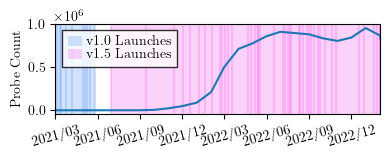

In [561]:
customfont = {'fontname':'CMU Sans Serif'}
matplotlib.rcParams.update({"font.size": 10})

tab_df = pd.read_csv("./data/mlab_starlink_data/ndt7_tableentrystats.csv").set_index("month")
starlink_launchdates = pd.read_csv("./data/gsp_scraped_starlink.csv")
starlink_launchdates["Date"] = starlink_launchdates["Date"].apply(lambda datestr: pd.to_datetime(datestr, format="%Y-%m-%d"))

# Long
#fig, ax = plt.subplots(figsize=(5.33, 2.8))

# Short
fig, ax = plt.subplots(figsize=(4, 1.7))
ax.plot(
    [datetime.fromisoformat(dt) for dt in tab_df.index],
    tab_df["entry_count"],
    color=cols[0]
)

import matplotlib.dates as mdates
myFmt = mdates.DateFormatter('%Y/%m')
ax.xaxis.set_major_formatter(myFmt)

# Long
#idx_range = (0, -2)
# Short
idx_range = (26, -2)
ax.set_xlim(
    datetime.fromisoformat(tab_df.index[idx_range[0]]),
    datetime.fromisoformat(tab_df.index[idx_range[1]])
)
tickslist = tab_df.index[idx_range[0]:idx_range[1] + 1][::3]
ax.set_xticks(tickslist)
ax.xaxis.set_tick_params(rotation=15)

def extract_rev_dates(rev):
    return [a for _, a in starlink_launchdates[starlink_launchdates["Revision"] == rev]["Date"].drop_duplicates().items()]
def plot_dates(dates, color, label):
    dates.sort()
    #print(dates)
    # TODO: regions
    if len(dates) == 0:
        return
    elif len(dates) == 1:
        ax.axvline(dates[0], color = color, label = label, zorder=1, alpha=0.3)
    else:
        ax.axvspan(dates[0], dates[-1], label = label, facecolor=color, zorder=1, alpha=0.3)
    for d in dates:
        ax.axvline(d, color = color, zorder=1, alpha=0.3)
        label = ""
    
#plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c88", label = "v0.9 Launch")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f588", label = "v1.0 Launches")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf088", label = "v1.5 Launches")
#plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63888", label = "v2 Launch")

#ax.annotate('29', xy=(datetime(year=2021, month=4, day=1), 100000), zorder=5)
#ax.annotate('50', xy=(datetime(year=2022, month=12, day=1), 100000), zorder=5)

plt.legend(loc='upper left', bbox_to_anchor=(0.0, 1.006),
          ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06, columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3)
#ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
    
ax.set_ylabel("Probe Count")
#ax.set_xlabel("Test Timestamp")
#plt.title("NDT7 Monthly Starlink Probe Count", **customfont)
plt.tight_layout()
#plt.show()
#plt.savefig('tessstttyyy.png', dpi=300)
plt.savefig("figures/mlab_probecount_withlaunch_short.pdf", pad_inches=0)
plt.savefig("figures/mlab_probecount_withlaunch_short.svg", bbox_inches="tight", pad_inches=0)
plt.show()

## Cities Overview

In [563]:
tab_df["entry_count"].sum()

10248868

## Global Probe Map

In [19]:
set(countries).difference(set(ndt7_df["ClientCountry"].drop_duplicates()))

{'Easter Island',
 'Ecuador',
 'El Salvador',
 'Finland',
 'Haiti',
 'Iceland',
 'Iran',
 'Luxembourg',
 'Panama',
 'Pitcairn Islands'}

In [20]:
ndt7countries_df = ndt7_df[ndt7_df["ClientCountry"].isin(countries)][["ClientCountry", "MeasurementCount"]].groupby(["ClientCountry"]).sum()
ndt7countries_df

,MeasurementCount
ClientCountry,
Australia,669911
Austria,14145
Belgium,18557
Brazil,154116
Bulgaria,53
Canada,1437942
Chile,61605
Colombia,13804
Croatia,64


In [21]:
len(ndt7countries_df)

52

In [22]:
(ndt7countries_df[ndt7countries_df["MeasurementCount"] <= 1000])

,MeasurementCount
ClientCountry,
Bulgaria,53
Croatia,64
Denmark,100
Estonia,75
Greece,217
Guadeloupe,624
Hungary,20
Jamaica,487
Latvia,50


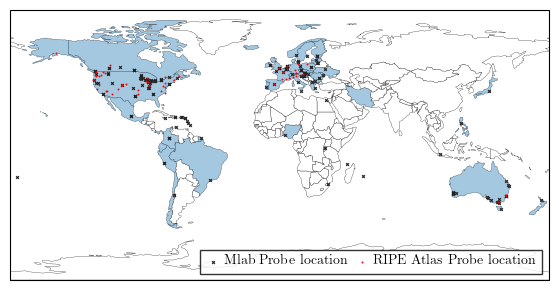

In [23]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
#world = world[(world.name!="Antarctica")]

def plotCountryPatch( axes, country_name, fcolor ):
    # plot a country on the provided axes
    nami = world[world.name == country_name]
    namigm = nami.__geo_interface__['features']  # geopandas's geo_interface
    namig0 = {'type': namigm[0]['geometry']['type'], \
              'coordinates': namigm[0]['geometry']['coordinates']}
    axes.add_patch(PolygonPatch( namig0, fc=fcolor, ec="black", alpha=0.4, zorder=2, linewidth=0.0 ))


fig, ax = plt.subplots(figsize=(7, 3), subplot_kw={'projection': ccrs.PlateCarree()})

cmap = colors.ListedColormap(cols[:-2])
world.plot(facecolor = "white", edgecolor="black", ax=ax, linewidth=0.2, alpha=1.0, zorder=0)

for c in countries:
    c = "United States of America" if c == "United States" else c
    c = "Czechia" if c == "Czech Republic" else c
    
    if(c in world["name"].values):
        plotCountryPatch(ax, c, matplotlib.colors.to_hex(cols[0]))
    #else:
    #    print(c)

def plot_extent(inclination, color="r", lw=1.4, alpha=0.7, lt="dotted"):
    label = "{}°".format(inclination)
    if inclination > 90:
        inclination = 90 - (inclination % 90)
    plt.plot([-180, 180], [ inclination,  inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha, label=label)
    plt.plot([-180, 180], [-inclination, -inclination], linewidth=lw, color=color, linestyle=lt, alpha=alpha)

#plot_extent(53, "r", lt="dotted", lw=0.8)
#plot_extent(70, "g", lt="dashed", lw=0.8)
#plot_extent(97.6, "b", lt="dashdot", lw=0.8)

#for x, y, label in zip(ndt7_df["lon"], ndt7_df["lat"], ndt7_df["ClientCountry"]):
#    ax.annotate(
#                    label,
#                    xy=(x, y),
#                    xytext=(2, 2),
#                    textcoords="offset points",
#                    fontsize=5
#    )
    

#ax.legend(loc='lower right', bbox_to_anchor=(1.00, -0.002),
#        ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06, columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3)
# ncol=3, fancybox=True, shadow=False)

#ax2 = ax.twinx()

latitude, longitude = ndt7_df["lat"], ndt7_df["lon"]
ax.scatter(longitude, latitude, 
               sizes = [6],
               linewidth = 0.1,
               color="#222222",
               zorder = 10,
                marker="X", label="Mlab Probe location")

latitude, longitude = ripe_loc_df["latitude"], ripe_loc_df["longitude"]
ax.scatter(longitude, latitude, 
               sizes = [1.5],
               linewidth = 0.1,
               color="#FF0000",
               zorder = 11,
                marker="o", label="RIPE Atlas Probe location")

ax.legend(loc='lower right', bbox_to_anchor=(1.00, -0.002),
        ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06, columnspacing=0.5, fancybox=False, shadow=False, handletextpad = 0.3)

ax.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

#ax2.set_extent([-180, 180, -90, 90], ccrs.PlateCarree())
#ax2.get_xaxis().set_ticks([])
#ax2.get_yaxis().set_ticks([])

plt.tight_layout()
plt.savefig("figures/mlab_probecities_overview_map.pdf")
plt.show()


# TODO:
# - Introduction: mention IP geolocation, GW locations, regions (AU, EU, NA, SA) SA AU EU NA 
# - Finish writing the paper report with that global collection and also use the coverage map

# TODO [ ]
# Filter out properly like discussed in skype (EU, SA <-> US, SA)
# Minrtt & htroughput globall
# Minrtt for regions individually
# Filter out cities not connecting with server from same city
# Endproduct: CDFs like now

# TODO: [ ] Check a fixed time periods and two regions
# fixed period -> Where the service starlink recently launched (maybe Ukraine) right after operational
# Compare with Country where it has been operational for a longer while
# Endproduct: Boxplot Time comparison, see sketch below. TBD which cities

# TODO: [ ] MNO analysis
# General comparison with mobile ISPs with Mlab data
# Filter out arm/android/ios OS -> Filter out server client not same city -> Which ASN do they have -> Which MNO do they belong -> Which MNO is most used per country? -> Filter out less popular MNO 
# -> Compare the MinRTT thorughput with Starlink probes
# Endprooduct: Boxplot per City

# TODO: [ ] coordinate histogram
# Endproduct: Map

# TODO: [ ] Weather Report, TBD on exact plots

# TODO: overlead TODOs
# Section 2
# TODO: add to overleaf and own paper: Coverage Map and 3d render

These are countries Outside of 53° latitude region. However: no probe is from outside of 53° coverage if we consider the line of sight coverage, even with 15° min elevation.

Loading the detailed city dataset

In [24]:
city_df.groupby(["client_Geo_City"])[["id"]].count().sort_values(by="id", ascending=False)

,id
client_Geo_City,
Seattle,1209763
Chicago,1102717
Dallas,1063634
Los Angeles,909044
Toronto,851021
New York,754640
Sydney,716134
London,486802
Denver,459403


## Stats ClientCity = ServerCity

In [25]:
# City List of cities with same client city as server city within filtered for Starlink probes with count of probes
from io import StringIO

pd.read_csv(StringIO("""
City with =	ProbeCount
Seattle	1220398
Chicago	1098253
Dallas	1038789
Atlanta	1009239
Los Angeles	918749
Toronto	761947
New York	740475
Sydney	659755
London	445902
Denver	440671
Mexico City	271860
Vancouver	188437
Auckland	96986
Montreal	87032
Calgary	83214
Paris	65717
Santiago	61471
Dublin	61340
Winnipeg	52273
Madrid	33761
Brussels	18461
Lisbon	14139
Prague	10054
Tokyo	8758
Amsterdam	7379
Lagos	7266
Lima	1697
Stockholm	658
Athens	193
Warsaw	130
Manila	78
Sofia	47
Maputo	31
Ljubljana	20
Jakarta	9
"""), delimiter="	")

,City with =,ProbeCount
0,Seattle,1220398
1,Chicago,1098253
2,Dallas,1038789
3,Atlanta,1009239
4,Los Angeles,918749
5,Toronto,761947
6,New York,740475
7,Sydney,659755
8,London,445902
9,Denver,440671


In [26]:
# City List of cities with same client city as server city within filtered for Starlink probes with count of probes
from io import StringIO

pd.read_csv(StringIO("""
City with !=,ProbeCount
Calgary,169254
Berlin,156570
São Paulo,154214
Winnipeg,86589
Rome,77123
Vienna,14113
Bogotá,13813
Auckland,12705
Chicago,11002
Lagos,9702
Sydney,8588
Toronto,8445
New York,6267
Dublin,5862
Los Angeles,4669
Atlanta,4582
Dallas,4382
Santo Domingo,4220
Seattle,4067
Mexico City,2743
Denver,2603
Fort-de-France,2335
Tokyo,2278
Charlotte Amalie,1973
Hampton,1622
San Juan,1339
Gustavia,1291
Vancouver,1282
Oslo,1269
London,1255
Warsaw,1145
Kyiv,835
Newaygo,827
Danbury,743
Montreal,713
Perth,627
Basse-Terre,624
Marigot,560
Kingston,552
Madrid,505
Shelburn,494
Lisbon,457
Hunnewell,445
Noojee,434
Wrenshall,411
Nuku'alofa,387
Fall River Mills,380
Paris,380
Howell,342
Kellevie,342
Santiago,311
Bororen,258
Pleasant View,256
Prague,244
Morganfield,235
Kalispell,224
Yinnar South,194
Mazomanie,190
Dorr,181
Adelaide Hills,163
Saint-Denis,158
Jakarta,154
Evansville,134
Copenhagen,100
Bucharest,99
Cayenne,96
Bratislava,95
Madison,79
Tallinn,75
Brussels,66
Zagreb,64
South Bend,59
Dedham,57
Huson,51
Riga,50
Lima,47
Fond du Lac,47
Rutherglen,44
Cairo,34
Vilnius,32
Eyota,30
Amsterdam,29
Mount Shasta,28
Andenne,26
Chippewa Falls,25
Athens,25
Kigali,21
Zurich,20
Budapest,20
Mandurah,16
Booroobin,15
Ljubljana,13
St Peter Port,11
Willemstad,9
M'Sapere,9
Corrigin,7
Manila,6
Sofia,6
Chisinau,6
Silverwood,6
Benayeo,5
Valletta,4
Bridgetown,4
Stockholm,4
Skopje,2
Myrtle Point,1
"""))[:15]

,City with !=,ProbeCount
0,Calgary,169254
1,Berlin,156570
2,São Paulo,154214
3,Winnipeg,86589
4,Rome,77123
5,Vienna,14113
6,Bogotá,13813
7,Auckland,12705
8,Chicago,11002
9,Lagos,9702


## IP Geolocation spread

The spread of IP geolocation is not even. In later cells, you will see that only the US, Australia, Canada, and Belgium have more than two cities geolocated by the IP annotator. I never got around to inspect the IP annotator in closer detail as to why this is, there is also the issue that I don't know exactly which IP annotator added the information to the ndt row (because it might change).

In [27]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
temp_df.reset_index().groupby(["ClientCountry"])[["ClientCity"]].count().sort_values(by="ClientCity", ascending=False)

,ClientCity
ClientCountry,
United States,31
Australia,12
Canada,5
Belgium,2
Romania,1
...,...
Jamaica,1
Japan,1
Latvia,1


The generated maps are generated here somewhere. I put this in this cell again as raw image just so we see the spread again

Spread in US:

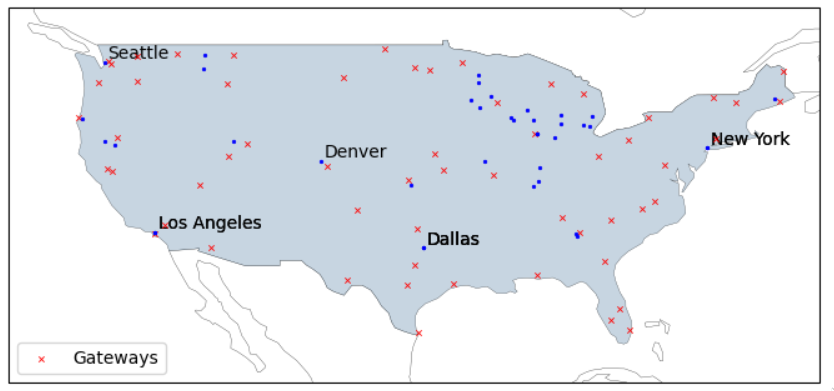

Spread in EU:

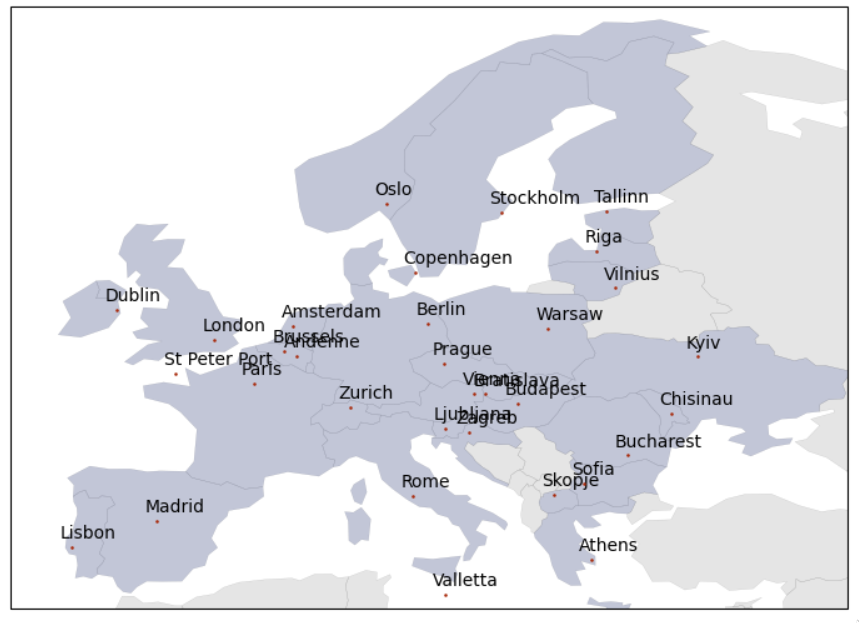

Spread in AU:

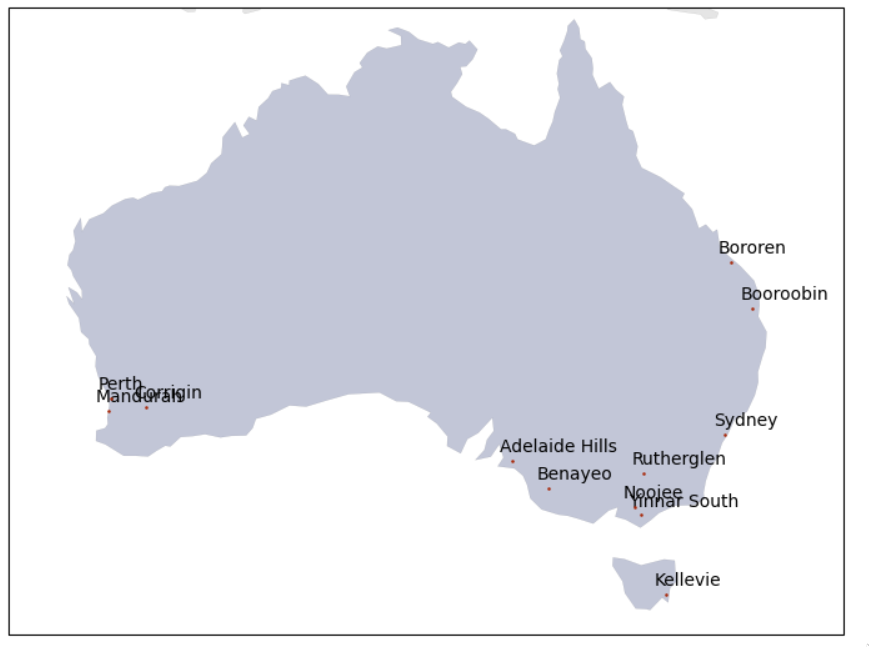

## Defining Global City Color and City Linestyle

asdasdasdasd

In [286]:
cols = plt.get_cmap("tab10").colors
lins
abs(hash("test")) % len(cols)

(0.8392156862745098, 0.15294117647058825, 0.1568627450980392)

In [294]:
lstyle_array

['solid', 'dotted', 'dashed', 'dashdot']

In [359]:
def assign_style(cityname):
    cols = plt.get_cmap("tab10").colors
    linestyle_array = ['solid', 'dotted', 'dashed', 'dashdot']
    
    offsetcolor = 0
    offsetline = 0
    
    if cityname == "New York":
        offsetcolor = -1
    elif cityname == "Seattle":
        offsetcolor = 2
    elif cityname == "Mexico City":
        offsetcolor = 1
    elif cityname == "Lima":
        offsetcolor = 2
        offsetline = 2
    elif cityname == "Paris":
        offsetcolor = 1
        offsetline = 12
    elif cityname == "London":
        offsetcolor = 2
        offsetline = 3
    elif cityname == "Perth":
        offsetcolor = 2
        offsetline = 3
    elif cityname == "Bororen":
        offsetcolor = 1
        offsetline = 12
    
    return cols[(offsetcolor + abs(hash(cityname))) % len(cols)], linestyle_array[(offsetline + abs(hash(cityname))) % len(linestyle_array)]

cities = city_df["client_Geo_City"].drop_duplicates().values
city_colors = {city: assign_style(city)[0] for city in city_df["client_Geo_City"].drop_duplicates().values}
lstyles = {city: assign_style(city)[1] for city in city_df["client_Geo_City"].drop_duplicates().values}

## 5 NA Cities

- Seattle
- Denver
- Dallas
- New York
- Los Angeles

In [28]:
len(city_df)

9150031

In [29]:
len(city_df[city_df["isDownload"] == False]) + len(city_df[city_df["isDownload"] == True])

9150031

In [454]:
interesting_cities = [
    "Seattle",
    "Denver",
    "Dallas",
    "New York",
    "Los Angeles"
]

#city_colors = {
#            "Seattle"     : "#7598b6",
#            "Denver"      : "#914c09",
#            "Los Angeles" : "#ce9c7f",
#            "Dallas"      : "#c1d5e2", 
#            "New York"    : "#663979"
#                }
#lstyles = {
#            "Seattle"     : "dotted",
#            "Denver"      : "solid",
#            "Los Angeles" : "dashed",
#            "Dallas"      : "solid", 
#            "New York"    : "dashdot"
#                }

#city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
#lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["NA"](city_df)

In [280]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_City"]
        ].groupby("server_Geo_City").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Seattle ===========
                     id
server_Geo_City        
Seattle          669427
========== Denver ===========
                     id
server_Geo_City        
Denver           251556
========== Dallas ===========
                     id
server_Geo_City        
Dallas           592083
========== New York ===========
                     id
server_Geo_City        
New York         417692
========== Los Angeles ===========
                     id
server_Geo_City        
Los Angeles      503369
========== Chicago ===========
                     id
server_Geo_City        
Chicago          613115
========== Atlanta ===========
Empty DataFrame
Columns: [id]
Index: []


In [32]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
temp_df.loc["United States",:].sort_values(by="MeasurementCount", ascending=False)[:10]

,MeasurementCount
ClientCity,
Seattle,1221524
Chicago,1105464
Dallas,1042030
Atlanta,1010926
Los Angeles,922460
New York,744442
Denver,441968
Hampton,1622
Newaygo,827


### Map

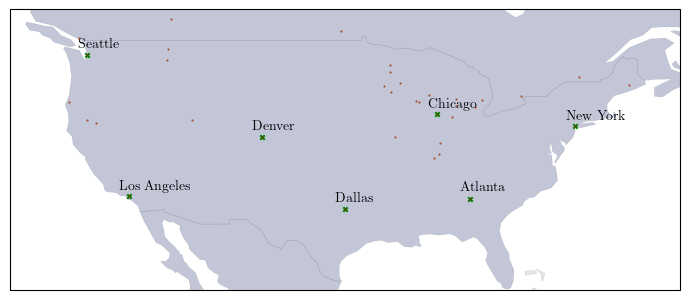

In [281]:
lon_bounds = (-130, -63.6)
lat_bounds = (25, 52)

plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lon_bounds = lon_bounds,
                   lat_bounds = lat_bounds,
                   annotate_minimal=True)

### Analysis

In [34]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

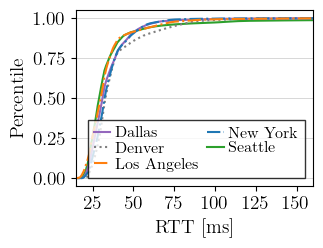

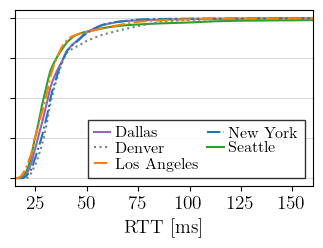

In [457]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xlim=(15, 160), xticks=[25, 50, 75, 100, 125, 150],
         figsize=(3.45, 2.7), savefig="mlab_cdf_minrtt_5nacities.pdf", city_colors=city_colors, lstyles=lstyles)
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xlim=(15, 160), ylabel="", stripylabels=True, xticks=[25, 50, 75, 100, 125, 150],
         figsize=(3.45, 2.7), savefig="mlab_cdf_minrtt_5nacities_stripped.pdf", city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)

## Mexico-Adjacent (Name suggestions welcome)

In [ ]:
interesting_cities = [
                "Mexico City"]

city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

### Map

In [ ]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lon_bounds = (-118.2,-50),
                   lat_bounds = (8.3, 28),
                   annotate_minimal=False)

In [ ]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lon_bounds = (-180,-30),
                   lat_bounds = (-60, 11),
                   annotate_minimal=False)

## 4 South American Cities
- São Paulo (BRA)
- Santiago (CHL)
- Bogotá (COL) 
- Lima (PRE)

In [458]:
interesting_cities = [
                "São Paulo",
                "Santiago",
                "Bogotá",
                "Lima"]

#city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

#lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["SA"](city_df)

In [160]:
df.groupby("client_Geo_City").count()

,id,date,isDownload,server_Site,server_Geo_CountryCode,server_Geo_CountryName,server_Geo_City,server_Geo_Latitude,server_Geo_Longitude,server_Network_CIDR,...,raw_ClientPort,a_TestTime,a_CongestionControl,a_MeanThroughputMbps,a_MinRTT,a_LossRate,a_MaxRTT,a_MedianThroughputMbps,client_Network_ASNumber,a_TestMonth
client_Geo_City,,,,,,,,,,,,,,,,,,,,,
Bogotá,17950,17950,17950,17950,17950,0,17950,17950,17950,17950,...,17950,17950,17950,17950,17950,17950,17950,17950,0,17950
Lima,4548,4548,4548,4548,4548,0,4548,4548,4548,4548,...,4548,4548,4548,4548,4548,4548,4548,4548,4548,4548
Santiago,41610,41610,41610,41610,41610,0,41610,41610,41610,41610,...,41610,41610,41610,41610,41610,41610,41610,41610,41610,41610
São Paulo,141245,141245,141245,141245,141245,0,141245,141245,141245,141245,...,141245,141245,141245,141245,141245,141245,141245,141245,141245,141245


In [161]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_CountryCode"]
        ].groupby("server_Geo_CountryCode").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== São Paulo ===========
                            id
server_Geo_CountryCode        
BR                      141245
========== Santiago ===========
                           id
server_Geo_CountryCode       
CL                      41610
========== Bogotá ===========
                           id
server_Geo_CountryCode       
CO                      17950
========== Lima ===========
                          id
server_Geo_CountryCode      
PE                      4548


### Map

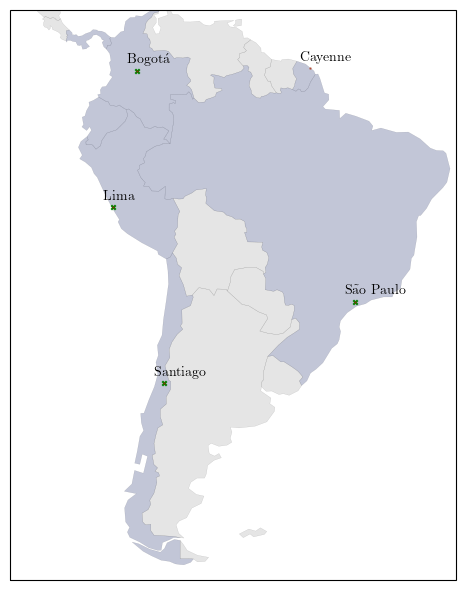

In [162]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lat_bounds = (-57.46, 12),
                   lon_bounds = (-90, -34),
                   annotate_minimal=False)

### CDF

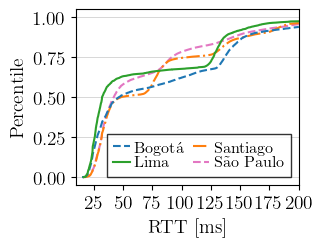

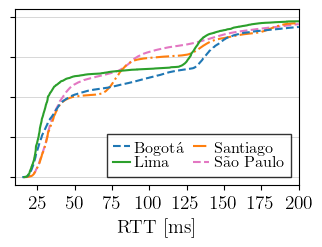

In [459]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_5sacities.pdf", xlim=(10, 200))
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_5sacities_stripped.pdf", xlim=(10, 200), ylabel="", stripylabels=True)
#plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Median Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles)

## 6 EU Cities

- Dublin, Ireland
- London, United Kingdom
- Berlin, Germany
- Kyiv, Ukraine
- Paris, France
- Rome, Italy

In [460]:
interesting_cities = [
                "Dublin",
                "London",
                "Berlin",
                "Paris",
                "Rome"]

#city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

#lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

#city_colors = {
#            "Sydney"       : "#7598b6",
#            "Perth"        : "#914c09",
#            "Noojee"       : "#ce9c7f",
#            "Kellevie"     : "#c1d5e2", 
#            "Bororen"      : "#663979"
#                }

#lstyles = {
#            "Sydney"       : "dotted",
#            "Perth"        : "solid",
#            "Noojee"       : "dashed",
#            "Kellevie"     : "solid", 
#            "Bororen"      : "dashdot"
#                }

df = region_filters["EU"](city_df)

In [283]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_CountryCode"]
        ].groupby("server_Geo_CountryCode").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Dublin ===========
                           id
server_Geo_CountryCode       
IE                      32794
========== London ===========
                            id
server_Geo_CountryCode        
GB                      272317
========== Berlin ===========
                           id
server_Geo_CountryCode       
DE                      80555
========== Paris ===========
                           id
server_Geo_CountryCode       
FR                      44769
========== Rome ===========
                           id
server_Geo_CountryCode       
IT                      52433


### Map

In [ ]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lat_bounds = (35, 72),
                   lon_bounds = (-13, 40),
                   annotate_minimal=True)

### Analysis

In [249]:
df.columns

Index(['id', 'date', 'isDownload', 'server_Site', 'server_Geo_CountryCode',
       'server_Geo_CountryName', 'server_Geo_City', 'server_Geo_Latitude',
       'server_Geo_Longitude', 'server_Network_CIDR',
       'server_Network_ASNumber', 'server_Network_ASName',
       'client_Geo_ContinentCode', 'client_Geo_CountryCode',
       'client_Geo_CountryName', 'client_Geo_City', 'client_Geo_Latitude',
       'client_Geo_Longitude', 'client_Geo_AccuracyRadiusKm',
       'client_Network_CIDR', 'raw_ServerIP', 'raw_ServerPort', 'raw_ClientIP',
       'raw_ClientPort', 'a_TestTime', 'a_CongestionControl',
       'a_MeanThroughputMbps', 'a_MinRTT', 'a_LossRate', 'a_MaxRTT',
       'GoodputMedian', 'GoodputMean', 'ThroughputMedian', 'ThroughputMean',
       'a_TestMonth', 'a_DiffRTT'],
      dtype='object')

In [519]:
city_df["date"].min()

'2021-06-30'

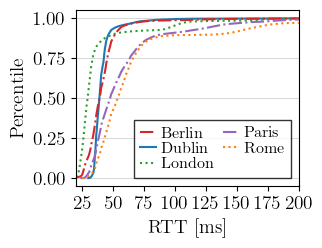

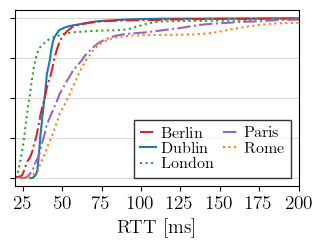

In [461]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df, interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_eucities.pdf", xlim=(20, 200))
plot_cdf(df, interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[25, 50, 75, 100, 125, 150, 175, 200],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_eucities_stripped.pdf", xlim=(20, 200), ylabel="", stripylabels=True)
#plot_cdf(df[df["isDownload"] == True], interesting_cities, "GoodputMean", "Mean Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_meangoodput_eucities.pdf")
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_medianthroughput_eucities.pdf")
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_lossrate_eucities.pdf")

## 5 Australian Cities

> Note: In terms of diversity of the IP geolocations, australie is the most diverse after the US. Outsie of Belgium, Canada, Australia, United States, other countries in the Mlab dataset only have one city per country as IP geolocation.

- Sydney, 666734
- Perth, 627
- Noojee, 434
- Kellevie, 342
- Bororen, 258
- Yinnar South, 194
- Adelaide Hills, 163

In [551]:
interesting_cities = [
                "Sydney",
                "Perth",
                "Noojee",
                "Kellevie",
                "Auckland"]

#city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

#lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = region_filters["AU"](city_df)
#df = city_df

In [324]:
temp_df = ndt7_df.groupby(["ClientCountry", "ClientCity"])[["MeasurementCount"]].sum()
temp_df.loc["Australia",:].sort_values(by="MeasurementCount", ascending=False)

,MeasurementCount
ClientCity,
Sydney,666734
Perth,627
Noojee,434
Kellevie,342
Bororen,258
Yinnar South,194
Adelaide Hills,163
Rutherglen,44
Mandurah,16


In [325]:
for c in interesting_cities:
    print("========== {} ===========".format(c))
    print(
        df[
            df["client_Geo_City"] == c
        ][
            ["id", "server_Geo_City"]
        ].groupby("server_Geo_City").count().sort_values("id", ascending=False)[:10]
    )
    print("===========================")

========== Sydney ===========
                     id
server_Geo_City        
Sydney           808442
Dallas             4405
Auckland           4166
Wellington         1529
Perth              1074
Melbourne          1021
Manila              119
Jakarta              41
Singapore            28
London               22
========== Perth ===========
                  id
server_Geo_City     
Sydney           836
Perth            175
Melbourne         15
Auckland           7
Wellington         7
Jakarta            6
========== Noojee ===========
                  id
server_Geo_City     
Sydney           462
========== Kellevie ===========
                  id
server_Geo_City     
Sydney           357
Wellington         2
========== Bororen ===========
                  id
server_Geo_City     
Sydney           276


### Map

In [ ]:
city_df["client_Geo_City"].drop_duplicates().values

In [ ]:
plot_probe_map(ndt7_df, city_df, interesting_cities,
                   lat_bounds = (-48.2, -10),
                   lon_bounds = (110, 180),
                   annotate_minimal=True)

### CDF

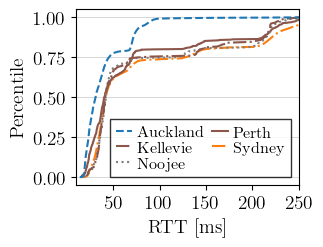

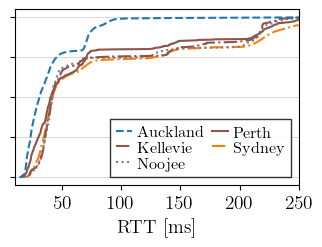

In [557]:
matplotlib.rcParams.update({"font.size": 14})
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]",
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, xlim=(10, 250), savefig="mlab_cdf_minrtt_5aucities.pdf", xticks=[50, 100, 150, 200, 250])
plot_cdf(df[df["isDownload"] == True], interesting_cities, "a_MinRTT", "RTT [ms]", xticks=[50, 100, 150, 200, 250],
             figsize=(3.45, 2.7), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_5aucities_stripped.pdf", xlim=(10, 250), ylabel="", stripylabels=True)
#plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_meanthroughput_5aucities.pdf")
#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_medianthroughput_5aucities.pdf")
#plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate [0-1]", 
#             figsize=(2.8, 2), city_colors=city_colors, lstyles=lstyles, savefig="cdf_lossrate_5aucities.pdf")

## 5 Global City Overview

- Seattle (USA)
- Mexico City (MEX)
- Bogotá (COL)
- Sydney (AUS)
- Dublin ()

In [70]:
sstr = "WHERE \n(\n{}\n)".format(" AND\n".join(
    ["\t(client.Geo.CountryName != \"{}\")".format(cn) for cn in city_df["client_Geo_CountryName"].drop_duplicates().values]
))

print(sstr)

WHERE 
(
	(client.Geo.CountryName != "United States") AND
	(client.Geo.CountryName != "Mexico") AND
	(client.Geo.CountryName != "Australia") AND
	(client.Geo.CountryName != "Colombia") AND
	(client.Geo.CountryName != "Norway") AND
	(client.Geo.CountryName != "Germany") AND
	(client.Geo.CountryName != "Canada") AND
	(client.Geo.CountryName != "Peru") AND
	(client.Geo.CountryName != "Chile") AND
	(client.Geo.CountryName != "Brazil") AND
	(client.Geo.CountryName != "Tonga") AND
	(client.Geo.CountryName != "France") AND
	(client.Geo.CountryName != "Italy") AND
	(client.Geo.CountryName != "Ukraine") AND
	(client.Geo.CountryName != "United Kingdom") AND
	(client.Geo.CountryName != "Ireland") AND
	(client.Geo.CountryName != "Martinique") AND
	(client.Geo.CountryName != "Sweden") AND
	(client.Geo.CountryName != "New Zealand") AND
	(client.Geo.CountryName != "Guadeloupe") AND
	(client.Geo.CountryName != "El Salvador") AND
	(client.Geo.CountryName != "Dominican Republic") AND
	(client.Geo.Countr

In [485]:
interesting_cities = [
        "Mexico City",
        "São Paulo",
        "Seattle",
        "Sydney",
        "Dublin",
        "Lagos",
        "Manila"
]
# Kyiv filtered out because it would be an interesting side-analysis

#city_colors = {
#            "Mexico City" : "#7598b6",
#            "Bogotá"      : "#914c09",
#            "Oslo"        : "#ce9c7f",
#            "Seattle"     : "#c1d5e2", 
#            "Sydney"      : "#663979"
#                }
#lstyles = {
#            "Mexico City" : "dotted",
#            "Bogotá"      : "solid",
#            "Oslo"        : "dashed",
#            "Seattle"     : "solid", 
#            "Sydney"      : "dashdot"
#                }
#cols = plt.get_cmap("tab10").colors
#city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}

#lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

df = city_df[ 
    city_df["client_Geo_City"].isin(interesting_cities)
]

# Filter out not same city / country
from unidecode import unidecode
df = df[((df["client_Geo_City"].map(unidecode) == df["server_Geo_City"].map(unidecode)) & df["client_Geo_CountryCode"].isin(["US", "AU"])) | (df["client_Geo_CountryCode"] == df["server_Geo_CountryCode"])]

down_df = df[df["isDownload"] == True]
up_df = df[df["isDownload"] == False]

# Execute below code to see to which cities a city connects to
#for city in interesting_cities:
#    print("===========================")
#    print(city)
#    print(df[df["client_Geo_City"] == city].groupby(["server_Geo_City"])[["id"]].count().sort_values(by="id", ascending=False)[:5])
#    print("===========================")

### Map

In [ ]:
plot_probe_map(ndt7_df, city_df, interesting_cities, figsize=(4.5, 2.4), annotate_minimal=True, savefig="mlab_probecities_global_highlighted.pdf")

### KDE Clustering

In [73]:
import numpy as np
import seaborn as sns

def kde_region(region, 
               bw_width=0.2,
               bw_adjust=0.5,
               linktype="both",
               xlabel="Median Throughput [Mbps]",
               col="a_MedianThroughputMbps",
               xlim=None,
               xticks_args=(np.arange(0, 320, 20), [str(tick) if (i)%5==0 and i>-1else "" for i, tick in enumerate(np.arange(0, 320, 20))]),
               figsize=(3.37, 2),
               dffilter = (lambda df: df),
               legendloc="upper right"
              ):
    fig, ax = plt.subplots(figsize=figsize)
    region_cities = {
        "au": [
                "Sydney",
                "Perth",
                "Noojee",
                "Kellevie",
                "Bororen"
        ],
        "eu": [
                "Dublin",
                "London",
                "Berlin",
                "Paris",
                "Rome"
        ],
        "sa": [
                "São Paulo",
                "Santiago",
                "Bogotá",
                "Lima"
        ],
        "na": [
                "Seattle",
                "Denver",
                "Dallas",
                "New York",
                "Los Angeles"
        ],
        "global": [
                "Mexico City",
                "São Paulo",
                "Seattle",
                "Sydney",
                "Dublin",
                "Lagos",
                "Manila"
        ]
    }
    interesting_cities = region_cities[region]

    city_colors = {city: cols[i % len(cols)] for i, city in enumerate(interesting_cities)}
    lstyles = {city: lstyle_array[i % len(lstyle_array)] for i, city in enumerate(interesting_cities)}

    df = city_df[ 
        city_df["client_Geo_City"].isin(interesting_cities)
    ]
    #df = df[df["a_MedianThroughputMbps"] > 0]
    from unidecode import unidecode
    df = df[(df["client_Geo_City"].map(unidecode) == df["server_Geo_City"]) | (df["client_Geo_CountryCode"].map(unidecode) == df["server_Geo_CountryCode"].map(unidecode))]
    #df = df[(df["client_Geo_City"].map(unidecode) == df["server_Geo_City"])]
    if linktype == "both":
        pass
    elif linktype == "up":
        df = df[df["isDownload"] == False]
    else:
        df = df[df["isDownload"] == True]
    df = dffilter(df)
    #print(df)
    #sns.kdeplot(city_df["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="KDE globally")

    #axs[0].hist(region_filters["AU"](city_df)["a_MedianThroughputMbps"], bins = 1000, label="AU")
    for city in interesting_cities:
        #print(city)
        sns.kdeplot(df[df["client_Geo_City"] == city][col], ax=ax, label=city, linestyle=lstyles[city], color=city_colors[city], bw_adjust=bw_adjust)
    #sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[1], label="SA")
    #sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[2], label="NA")
    #sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[3], label="EU")
    #sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="SA", bw_adjust=.05)
    #sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="NA", bw_adjust=.05)
    #sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="EU", bw_adjust=.05)

    # Setting axis labels
    ax.set_xlabel(xlabel)
    #ax.set_ylabel("Percentile")

    if xlim:
        ax.set_xlim(xlim)
    if xticks_args:
        ax.set_xticks(*xticks_args)
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False
    #ax.xaxis.set_tick_params(rotation=15)

    ax.legend(loc=legendloc, fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
    plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

    fig.tight_layout()
    plt.savefig("figures/mlab_kde_{}_{}_{}.pdf".format(col, region, linktype), bbox_inches = "tight", pad_inches = 0)
    plt.show()


Goodput Median:


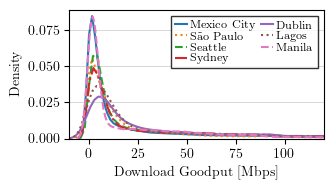

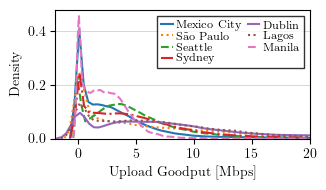

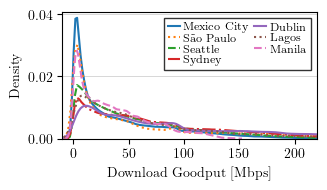

Goodput Mean:


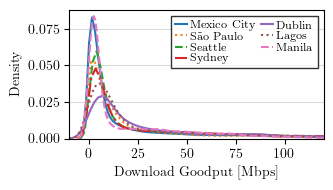

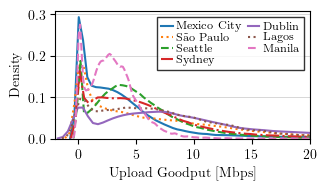

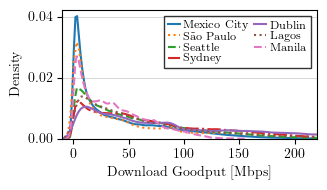

Mean Throughput given by Mlab:


SyntaxError: keyword argument repeated: xlim (14193984.py, line 11)

In [45]:
print("Goodput Median:")
kde_region("global", linktype="both", xlabel="Download Goodput [Mbps]", xlim=(-10, 120), col="GoodputMedian", xticks_args=())
kde_region("global", linktype="up",   xlabel="Upload Goodput [Mbps]", xlim=(-2, 20), xticks_args=(), col="GoodputMedian")
kde_region("global", linktype="down", xlabel="Download Goodput [Mbps]", xlim=(-10, 220), col="GoodputMedian", xticks_args=())

print("Goodput Mean:")
kde_region("global", linktype="both", xlabel="Download Goodput [Mbps]", xlim=(-10, 120), col="GoodputMean", xticks_args=())
kde_region("global", linktype="up",   xlabel="Upload Goodput [Mbps]", xlim=(-2, 20), col="GoodputMean", xticks_args=())
kde_region("global", linktype="down", xlabel="Download Goodput [Mbps]", xlim=(-10, 220), col="GoodputMean", xticks_args=())

print("Mean Throughput given by Mlab:")
kde_region("global", linktype="up", xlabel="Upload Throughput [Mbps]", col="a_MeanThroughputMbps", xlim=(-1, 40), xticks_args=())
kde_region("global", linktype="down", xlabel="Download Throughput [Mbps]", col="a_MeanThroughputMbps", xlim=(-5, 300), xticks_args=())

no filter


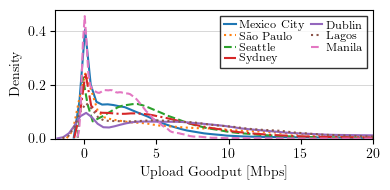

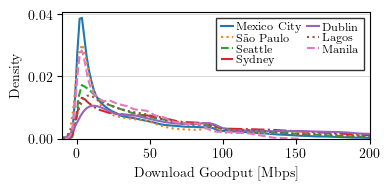

In [47]:
print("no filter")

kde_region("global",
               linktype="up",
               xlabel="Upload Goodput [Mbps]",
               xlim=(-2, 20),
               xticks_args=(),
               col="GoodputMedian",
               figsize=(4, 2)
          )
kde_region("global",
               linktype="down",
               xlabel="Download Goodput [Mbps]",
               xlim=(-10, 200),
               col="GoodputMedian",
               xticks_args=(),
               figsize=(4, 2)
          )

filter Goodput > 1


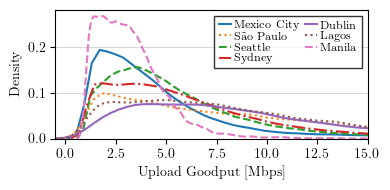

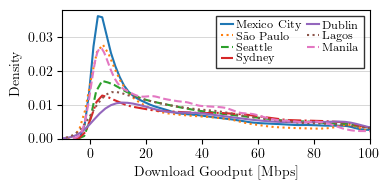

In [74]:
print("filter Goodput > 1")

kde_region("global",
               linktype="up",
               xlabel="Upload Goodput [Mbps]",
               xlim=(-0.5, 15),
               xticks_args=(),
               col="GoodputMedian",
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 1])
          )
kde_region("global",
               linktype="down",
               xlabel="Download Goodput [Mbps]",
               xlim=(-10, 100),
               col="GoodputMedian",
               xticks_args=(),
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 1])
          )

filter Goodput > 5


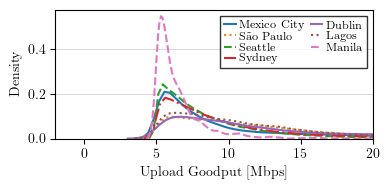

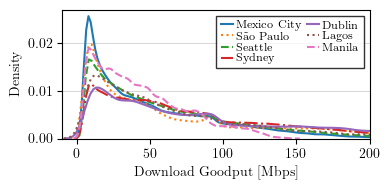

In [53]:
print("filter Goodput > 5")

kde_region("global",
               linktype="up",
               xlabel="Upload Goodput [Mbps]",
               xlim=(-2, 20),
               xticks_args=(),
               col="GoodputMedian",
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 5])
          )
kde_region("global",
               linktype="down",
               xlabel="Download Goodput [Mbps]",
               xlim=(-10, 200),
               col="GoodputMedian",
               xticks_args=(),
               figsize=(4, 2),
               dffilter = (lambda ddf: ddf[ddf["GoodputMedian"] > 5])
          )

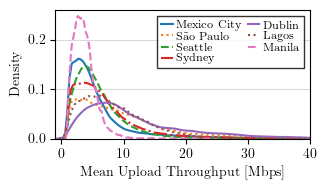

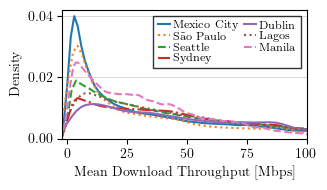

In [320]:
#kde_region("global", xlabel="Median Throughput [Mbps]", xlim=(-5, 200), figsize=(4.5, 2))
#kde_region("global", linktype="up", xlabel="Median Upload Throughput [Mbps]", xlim=(0.75, 1.8), xticks_args=(), figsize=(4.5, 2),
#                      dffilter = (lambda ddf: ddf[ddf["a_MedianThroughputMbps"] > 1.0]), legendloc="upper left")
#kde_region("global", linktype="down", xlabel="Median Download Throughput [Mbps]", xlim=(-5, 150), figsize=(4.5, 2), xticks_args=())

kde_region("global", 
               linktype="up",
               xlabel="Mean Upload Throughput [Mbps]", 
               col="a_MeanThroughputMbps",
               xlim=(-1, 40),
               xticks_args=(),
               dffilter = (lambda ddf: ddf[ddf["a_MeanThroughputMbps"] > 1.0]))
kde_region("global", 
                linktype="down",
               xlabel="Mean Download Throughput [Mbps]",
               col="a_MeanThroughputMbps",
               xlim=(-2, 100),
               xticks_args=(),
               dffilter = (lambda ddf: ddf[ddf["a_MeanThroughputMbps"] > 1.0]))

In [316]:
city_df["a_MedianThroughputMbps"].mean()

32.05633522721893

### CDF Analysis

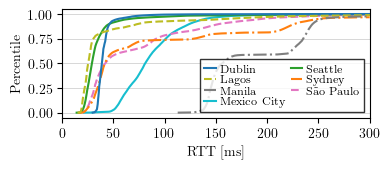

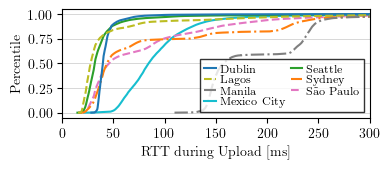

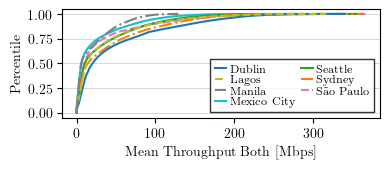

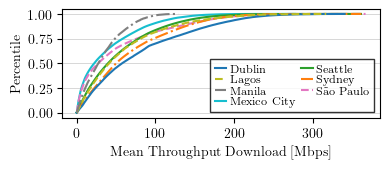

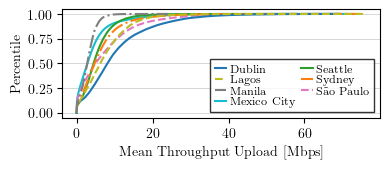

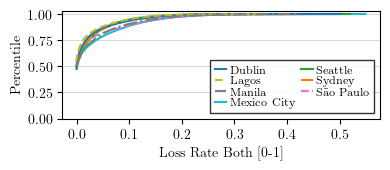

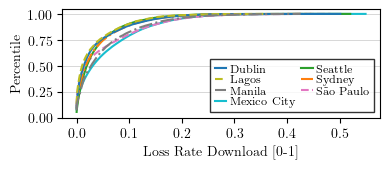

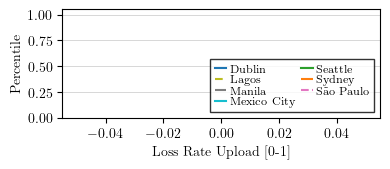

In [466]:
matplotlib.rcParams.update({"font.size": 10})
plot_cdf(down_df, interesting_cities, "a_MinRTT", "RTT [ms]", 
             figsize=(4, 1.8), xlim=(0, 300), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_minrtt_globalcities.pdf")

plot_cdf(up_df, interesting_cities, "a_MinRTT", "RTT during Upload [ms]", 
             figsize=(4, 1.8), xlim=(0, 300), city_colors=city_colors, lstyles=lstyles)

plot_cdf(df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput Both [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles)

plot_cdf(down_df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput Download [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_meanthroughput-down_globalcities.pdf")
plot_cdf(up_df, interesting_cities, "a_MeanThroughputMbps", "Mean Throughput Upload [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_meanthroughput-up_globalcities.pdf")

#plot_cdf(down_df, interesting_cities, "a_MedianThroughputMbps", "Median Throughput Download [Mbps]", 
#             figsize=(4, 2), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_medianthroughput-down_globalcities.pdf")
#plot_cdf(up_df, interesting_cities, "a_MedianThroughputMbps", "Median Throughput Upload [Mbps]", 
#             figsize=(4, 2), city_colors=city_colors, lstyles=lstyles, xlim=(0, 0.1), savefig="mlab_cdf_medianthroughput-up_globalcities.pdf")

#plot_cdf(df, interesting_cities, "a_MedianThroughputMbps", "Throughput [Mbps]", 
#             figsize=(3.37, 2), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_medianthroughput_globalcities.pdf")
plot_cdf(df, interesting_cities, "a_LossRate", "Loss Rate Both [0-1]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles)
plot_cdf(down_df, interesting_cities, "a_LossRate", "Loss Rate Download [0-1]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_lossrate-down_globalcities.pdf")
plot_cdf(up_df, interesting_cities, "a_LossRate", "Loss Rate Upload [0-1]", 
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles)

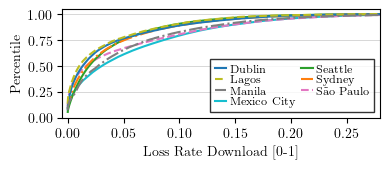

In [483]:
matplotlib.rcParams.update({"font.size": 10})
plot_cdf(down_df, interesting_cities, "a_LossRate", "Loss Rate Download [0-1]", xlim=(-0.005, 0.28),
             figsize=(4, 1.8), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_lossrate-down_globalcities.pdf")

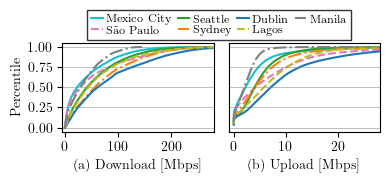

In [549]:
#plot_cdf(df, interesting_cities, "GoodputMedian", "Goodput [Mbps]", 
#             figsize=(4, 1.7), city_colors=city_colors, xlim=(-5, 300), lstyles=lstyles, savefig="mlab_cdf_mediangoodput-both_globalcities.pdf")

fig, axs = plt.subplots(1, 2, figsize=(4, 1.6))

plot_cdf(down_df, interesting_cities, "GoodputMedian", "(a) Download [Mbps]",
                  show=False, ax=axs[0], skiplegend=True,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(-5, 280), lstyles=lstyles)

plot_cdf(up_df,  interesting_cities, "GoodputMedian", "(b) Upload [Mbps]", 
                show=False, ax=axs[1], skiplegend=False,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(-1, 28), lstyles=lstyles)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.25, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.50, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.75, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(1.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          fontsize="small", ncol=4, edgecolor="k", handlelength=1, labelspacing=0.06, bbox_to_anchor=(0.56, 1.15),
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)

axs[1].get_legend().remove()

fig.tight_layout()
plt.savefig(os.path.join("figures", "mlab_cdf_mediangoodput-both_globalcities.pdf"), bbox_inches="tight", pad_inches=0)
plt.show()

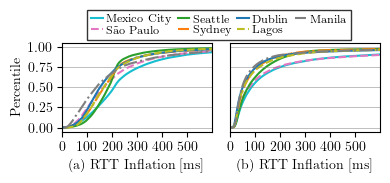

In [550]:
#plot_cdf(df, interesting_cities, "GoodputMedian", "Goodput [Mbps]", 
#             figsize=(4, 1.7), city_colors=city_colors, xlim=(-5, 300), lstyles=lstyles, savefig="mlab_cdf_mediangoodput-both_globalcities.pdf")

fig, axs = plt.subplots(1, 2, figsize=(4, 1.6))

plot_cdf(down_df, interesting_cities, "a_DiffRTT", "(a) RTT Inflation [ms]",
                  show=False, ax=axs[0], skiplegend=True,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(0, 600), lstyles=lstyles)

plot_cdf(up_df,  interesting_cities, "a_DiffRTT", "(b) RTT Inflation [ms]", 
                show=False, ax=axs[1], skiplegend=False,
             figsize=(4, 1.7), city_colors=city_colors, xlim=(0, 600), lstyles=lstyles)
axs[1].set_ylabel("")
axs[1].set_yticks([])
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.25, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.50, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(0.75, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")
axs[1].axhline(1.00, linestyle='-', alpha=0.7, linewidth=0.5, color="grey")

handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center',
          fontsize="small", ncol=4, edgecolor="k", handlelength=1, labelspacing=0.06, bbox_to_anchor=(0.56, 1.15),
                  columnspacing=0.5, handletextpad=0.3, fancybox=False)

axs[1].get_legend().remove()

axs[0].set_xticks(np.arange(0, 600, 100))
axs[1].set_xticks(np.arange(0, 600, 100))

fig.tight_layout()
plt.savefig(os.path.join("figures", "mlab_cdf_diffrtt-both_globalcities.pdf"), bbox_inches="tight", pad_inches=0)
plt.show()

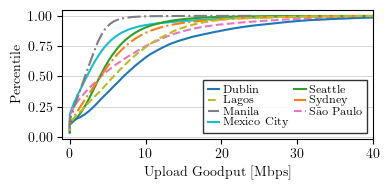

In [408]:
plot_cdf(up_df, interesting_cities, "GoodputMedian", "Upload Goodput [Mbps]", 
             figsize=(4, 1.8), city_colors=city_colors, xlim=(-1, 40), lstyles=lstyles, savefig="mlab_cdf_mediangoodput-up_globalcities.pdf")

In [ ]:
plot_cdf(down_df, 
         interesting_cities, "GoodputMedian", "Download Goodput [Mbps]", 
         figsize=(4, 2), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_mediangoodput-down_globalcities.pdf",
         xticks=np.arange(0, 250, 50),
        xlim=(-5, 270))

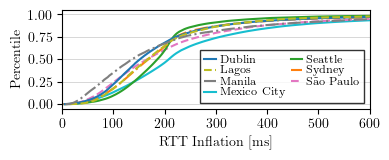

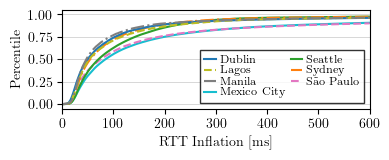

In [471]:
plot_cdf(down_df, interesting_cities, "a_DiffRTT", "RTT Inflation [ms]", 
             figsize=(4, 1.7), xlim=(0, 600), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_diffrtt_down_globalcities.pdf", legendloc="lower right")

plot_cdf(up_df, interesting_cities, "a_DiffRTT", "RTT Inflation [ms]", 
             figsize=(4, 1.7), xlim=(0, 600), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_diffrtt_up_globalcities.pdf")

In [195]:
print("Download max lossrate {}; Downlad min lossrate {};".format(down_df["a_LossRate"].max(), down_df["a_LossRate"].min()))
print("Upload max lossrate {}; Upload min lossrate {};".format(up_df["a_LossRate"].max(), up_df["a_LossRate"].min()))

Download max lossrate 0.730298827386206; Downlad min lossrate 0.0;
Upload max lossrate 0.0; Upload min lossrate 0.0;


### Over entire Time Range

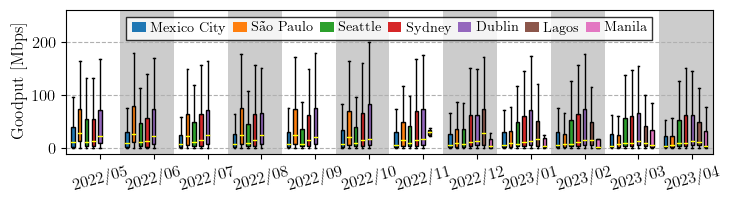

In [ ]:
matplotlib.rcParams.update({"font.size": 12})
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: df[(df["client_Geo_City"] == c) & (df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(7.5, 2.2),
                             ylim=(-10, 260),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="mlab_throughput_globalcities_2022-03_to_2023-04.pdf", ylabel="Goodput [Mbps]",
                             orientation="upper center"
                        )

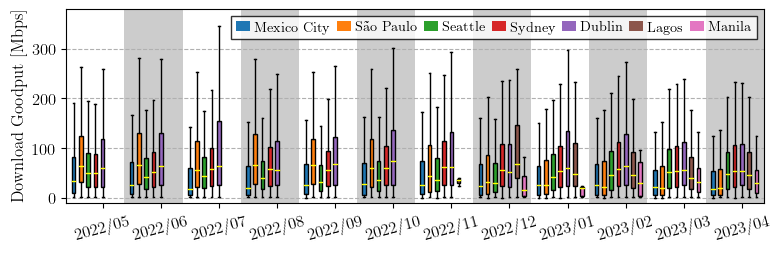

In [421]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: down_df[(down_df["client_Geo_City"] == c) & (down_df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                         ylim=(-10, 380),
                             nlegendcols=7,
                             savefig="mlab_goodputmedian-down_globalcities_2022-03_to_2023-04.pdf", ylabel="Download Goodput [Mbps]",
                             orientation="upper right"
                        )

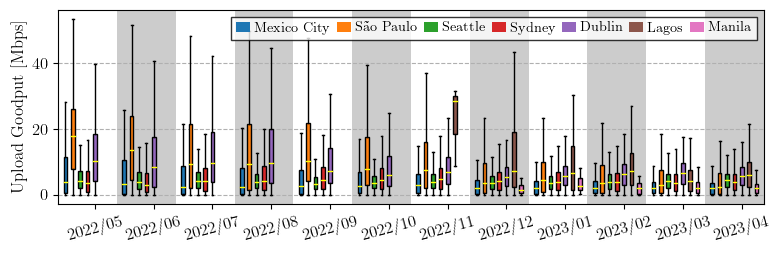

In [423]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: up_df[(up_df["client_Geo_City"] == c) & (up_df["a_TestMonth"] == month)]["GoodputMedian"]
         for c in interesting_cities} for month in months_array
]

# Mean throughput
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="mlab_goodputmedian-up_globalcities_2022-03_to_2023-04.pdf", ylabel="Upload Goodput [Mbps]",
                             orientation="upper right"
                        )

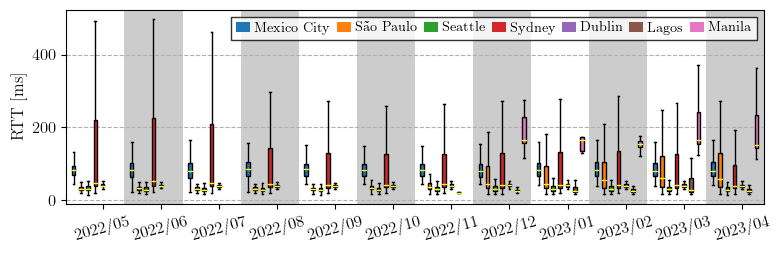

In [425]:
months_array = df[["a_TestMonth"]].drop_duplicates().sort_values("a_TestMonth")["a_TestMonth"]
datetime_array = [datetime.fromisoformat(str(dt_str)) for dt_str in months_array]
data_array = [
    {c: down_df[(down_df["client_Geo_City"] == c) & (down_df["a_TestMonth"] == month)]["a_MinRTT"]
         for c in interesting_cities} for month in months_array
]

# MinRTT
plot_boxplot_progression(datetime_array[-12:], data_array[-12:],
                            figsize=(8, 2.7),
                            figures_path="figures",
                             nlegendcols=7,
                             savefig="mlab_minrtt_globalcities_2022-03_to_2023-04.pdf", ylabel="RTT [ms]",
                             orientation="upper right"
                        )

In [50]:
for d, m in zip(data_array, months_array):
    print("================")
    print(m)
    print(d.keys())
    print([len(arr) for arr in d.values()])
    print("================")

2021-07-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 0, 3, 0, 0]
2021-08-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 0, 13, 0, 0]
2021-09-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 0, 24, 0, 0]
2021-10-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 0, 1926, 0, 0]
2021-11-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 0, 6641, 0, 0]
2021-12-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 6, 10228, 0, 0]
2022-01-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[0, 0, 16392, 0, 0]
2022-02-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[23, 11, 17486, 0, 1145]
2022-03-01 00:00:00
dict_keys(['Mexico City', 'São Paulo', 'Seattle', 'Sydney', 'Dublin'])
[433, 10, 30640, 9393, 2378]

In [126]:
city_df

,id,date,a_TestTime,a_CongestionControl,a_MeanThroughputMbps,a_MinRTT,a_LossRate,server_Site,server_Geo_CountryCode,server_Geo_CountryName,...,client_Geo_Latitude,client_Geo_Longitude,client_Geo_AccuracyRadiusKm,client_Network_CIDR,raw_ServerIP,raw_ServerPort,raw_ClientIP,raw_ClientPort,a_MedianThroughputMbps,a_TestMonth
0,ndt-virtual-6tgkw_1659632211_000000000007DFD0,2022-09-10,2022-09-10 14:42:18.296220,bbr,80.906753,37.349,0.016326,sea09,US,NaN,...,47.6034,-122.3414,20,98.97.32.0/21,10.4.0.4,443,98.97.34.4,4489,86.595670,2022-09-01
1,ndt-virtual-6tgkw_1659632211_0000000000080640,2022-09-10,2022-09-10 19:47:50.064087,bbr,55.688317,34.420,0.022693,sea09,US,NaN,...,47.6034,-122.3414,20,98.97.32.0/21,10.4.0.4,443,98.97.35.61,19705,64.692583,2022-09-01
2,ndt-virtual-6tgkw_1659632211_000000000007EFA7,2022-09-10,2022-09-10 23:51:00.743294,bbr,10.786896,39.629,0.011311,sea09,US,NaN,...,47.6034,-122.3414,20,98.97.32.0/21,10.4.0.4,443,98.97.34.86,53758,12.080500,2022-09-01
3,ndt-virtual-6tgkw_1659632211_000000000008033B,2022-09-10,2022-09-10 14:24:36.396017,bbr,66.336473,34.833,0.037669,sea09,US,NaN,...,47.6034,-122.3414,20,98.97.112.0/21,10.4.0.4,443,98.97.112.27,58739,60.531966,2022-09-01
4,ndt-virtual-6tgkw_1659632211_0000000000081415,2022-09-10,2022-09-10 22:22:52.986390,bbr,39.703695,37.632,0.042583,sea09,US,NaN,...,47.6034,-122.3414,20,98.97.112.0/21,10.4.0.4,443,98.97.115.10,29040,42.361451,2022-09-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96427,ndt-c6xdf_1671038128_00000000000E1D8A,2022-12-29,2022-12-29 05:34:44.899486,bbr,170.922785,47.495,0.002232,syd05,AU,NaN,...,-36.8506,174.7679,500,2406:2d40:7000::/38,2402:7800:200f:1::75,443,2406:2d40:7214:c910:aa5d:9b64:d3e3:f1a0,52750,195.719110,2022-12-01
96428,ndt-t26jp_1673743736_00000000001E1F0E,2023-02-12,2023-02-12 20:10:28.793966,bbr,30.776291,50.656,0.049289,syd05,AU,NaN,...,-36.8506,174.7679,200,2406:2d40:7000::/38,2402:7800:200f:1::101,443,2406:2d40:72e2:510:5421:3671:6684:9fb5,40654,26.682877,2023-02-01
96429,ndt-pdqdq_1673597123_000000000021C98D,2023-02-12,2023-02-12 08:01:52.385358,bbr,7.724176,53.602,0.108070,syd05,AU,NaN,...,-36.8506,174.7679,200,2406:2d40:7000::/38,2402:7800:200f:1::88,443,2406:2d40:720e:de10:4bf:5da8:324:5974,64827,8.586035,2023-02-01
96430,ndt-pdqdq_1673597123_000000000021D84B,2023-02-12,2023-02-12 04:38:03.161719,bbr,0.739727,73.351,0.000000,syd05,AU,NaN,...,-36.8506,174.7679,200,2406:2d40:7000::/38,2402:7800:200f:1::88,443,2406:2d40:7206:2410:c21:3:7195:def8,44438,0.912927,2023-02-01


## Kernel Density Estimation Function

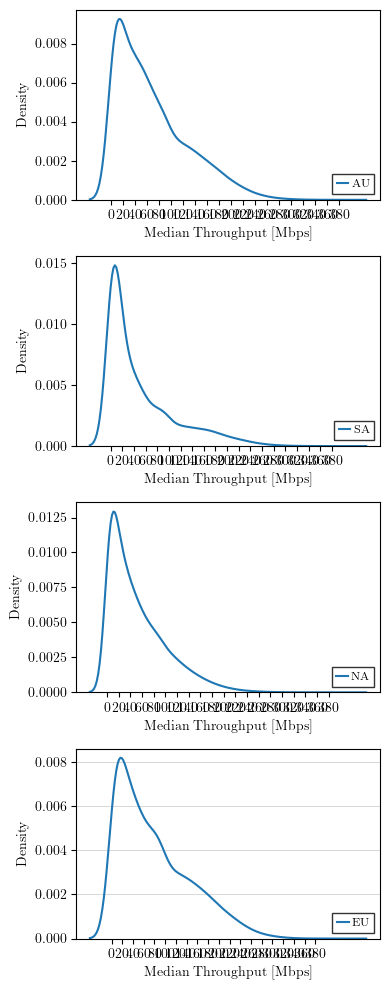

In [47]:
import numpy as np
import seaborn as sns

fig, axs = plt.subplots(4, figsize=(4, 10))

# Create CDF plot
#sns.kdeplot(city_df["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="KDE globally")

#axs[0].hist(region_filters["AU"](city_df)["a_MedianThroughputMbps"], bins = 1000, label="AU")
sns.kdeplot(region_filters["AU"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[0], label="AU")
sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[1], label="SA")
sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[2], label="NA")
sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.2, ax=axs[3], label="EU")
#sns.kdeplot(region_filters["SA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="SA", bw_adjust=.05)
#sns.kdeplot(region_filters["NA"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="NA", bw_adjust=.05)
#sns.kdeplot(region_filters["EU"](city_df)["a_MedianThroughputMbps"], bw_method=0.5, ax=ax, label="EU", bw_adjust=.05)

# Setting axis labels
for ax in axs:
    ax.set_xlabel("Median Throughput [Mbps]")
    #ax.set_ylabel("Percentile")

    ax.set_xticks(np.arange(0, 400, 20))
    ax.xaxis.get_major_formatter()._usetex = False
    ax.yaxis.get_major_formatter()._usetex = False

    ax.legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
              columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

fig.tight_layout()
# plt.savefig("example.pdf", bbox_inches = "tight", pad_inches = 0)
plt.show()


In [46]:
eu_df = region_filters["EU"](city_df)
eu_df[eu_df["a_MedianThroughputMbps"] < 0]

,id,date,a_TestTime,a_CongestionControl,a_MeanThroughputMbps,a_MinRTT,a_LossRate,server_Site,server_Geo_CountryCode,server_Geo_CountryName,...,client_Geo_Latitude,client_Geo_Longitude,client_Geo_AccuracyRadiusKm,client_Network_CIDR,raw_ServerIP,raw_ServerPort,raw_ClientIP,raw_ClientPort,a_MedianThroughputMbps,a_TestMonth


<Axes: ylabel='Density'>

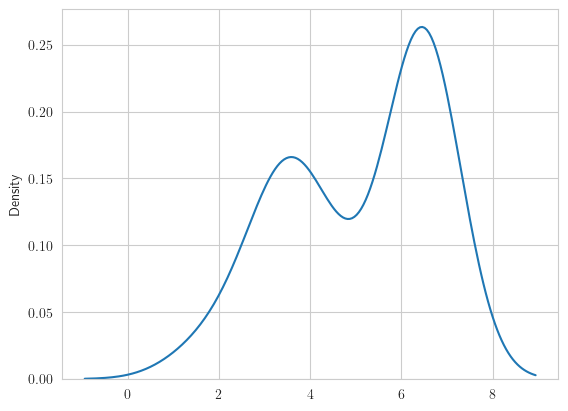

In [131]:
data = [1.5] + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*16
#sns.set_style('whitegrid')
sns.kdeplot(data, bw_method=0.5)

### Time Sensitive

In [51]:
comparison_df = pd.DataFrame()
comparison_df["OverallCount"] = df.groupby("client_Geo_City")["a_TestTime"].count()
comparison_df["OverallPreOctober"] = df[df["a_TestTime"] < datetime(year=2022, month=10, day=1)].groupby("client_Geo_City")["a_TestTime"].count()
comparison_df["OverallPostOctober"] = df[df["a_TestTime"] > datetime(year=2022, month=10, day=1)].groupby("client_Geo_City")["a_TestTime"].count()
comparison_df

,OverallCount,OverallPreOctober,OverallPostOctober
client_Geo_City,,,
Dublin,39553,18277,21276
Mexico City,210827,40164,170663
Seattle,797706,431541,366165
Sydney,456326,147343,308983
São Paulo,107216,12511,94705


In [52]:
# Grouping per Month
month_grouped = df.groupby(["client_Geo_City", "a_TestMonth"]).count()[["a_TestTime"]]
month_grouped = month_grouped.rename(columns={"a_TestTime": "ProbeCount"})
month_grouped["MeanMinRTT"] = df.groupby(["client_Geo_City", "a_TestMonth"]).mean(numeric_only=True)["a_MinRTT"]
month_grouped["MeanThroughputMbps"] = df.groupby(["client_Geo_City", "a_TestMonth"]).mean(numeric_only=True)["a_MeanThroughputMbps"]
month_grouped["MeanLossRate"] = df.groupby(["client_Geo_City", "a_TestMonth"]).mean(numeric_only=True)["a_LossRate"]
month_grouped = month_grouped.reset_index()

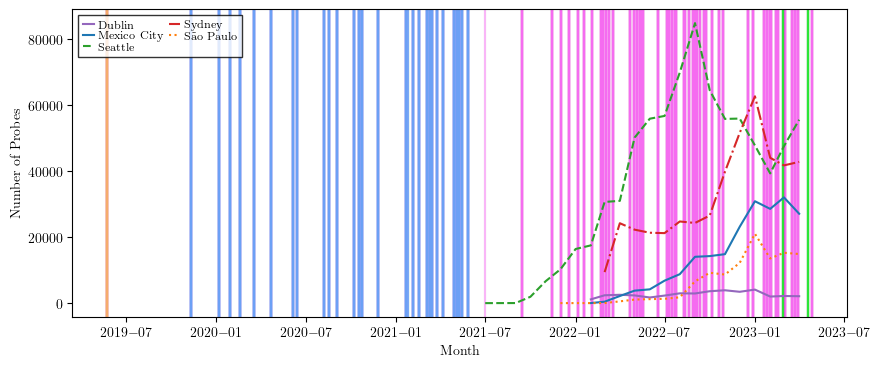

In [53]:
# Compaing Monthly amount of probes for each city
selected_cities = comparison_df.index

def extract_rev_dates(rev):
    return [a for _, a in starlink_launchdates[starlink_launchdates["Revision"] == rev]["Date"].items()]
def plot_dates(dates, color, label):
    for d in dates:
        ax.axvline(d,
                   color = color, label = label, zorder=1)
        label = ""

fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["ProbeCount"], label=city, color=city_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Number of Probes")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

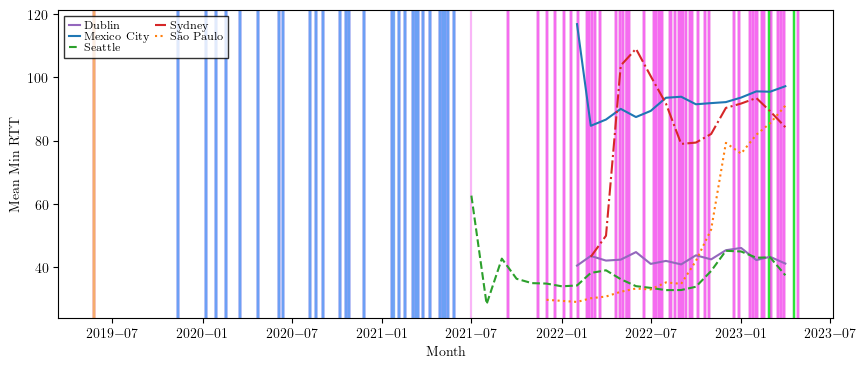

In [54]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["MeanMinRTT"], label=city, color=city_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Mean Min RTT")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

NameError: name 'continent_colors' is not defined

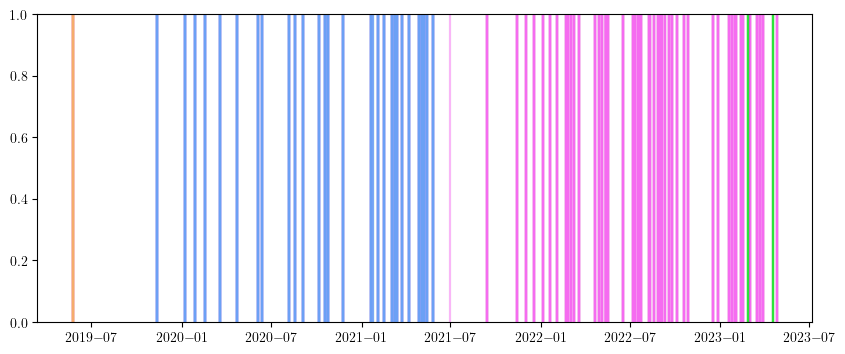

In [55]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["MeanThroughputMbps"], label=city, color=continent_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Mean Throughput Mbps")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
#plt.savefig("temp.png", dpi=300)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 4))

plot_dates(extract_rev_dates("v0.9"), color = "#f5ac6c33", label="")
plot_dates(extract_rev_dates("v1.0"), color = "#6ca0f533", label="")
plot_dates(extract_rev_dates("v1.5"), color = "#f56cf033", label="")
plot_dates(extract_rev_dates("v2-Mini"), color = "#2ce63833", label="")

for city in selected_cities:
    temp_df = month_grouped[month_grouped["client_Geo_City"] == city].sort_values("a_TestMonth")
    ax.plot(temp_df["a_TestMonth"], temp_df["MeanLossRate"], label=city, color=continent_colors[city], linestyle=lstyles[city])

ax.set_xlabel("Month")
ax.set_ylabel("Mean Loss Rate")
ax.legend(loc="upper left", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)

In [ ]:
timerange0 = (datetime(year=2021, month=12, day=3), datetime(year=2021, month=12, day=5))
timerange1 = (datetime(year=2022, month=1, day=3), datetime(year=2022, month=1, day=5))
timerange2 = (datetime(year=2022, month=2, day=3), datetime(year=2022, month=2, day=5))
timerange3 = (datetime(year=2022, month=3, day=3), datetime(year=2022, month=3, day=5))

ranges = [timerange0, timerange1, timerange2, timerange3]
names = ["Dec. 3-4", "Jan. 3-4", "Feb. 3-4", "Mar. 3-4"]

In [ ]:
df_ranges = [df[(df["a_TestTime"] > tr[0]) & (df["a_TestTime"] < tr[1])] for tr in ranges]
df_ranges[0].columns

In [ ]:
fig, axs = plt.subplots(3, 1)

axs[0].boxplot([df_range["a_MinRTT"] for df_range in df_ranges])
axs[0].set_title("MinRTT")
axs[0].set_xticklabels(names)

axs[1].boxplot([df_range["a_MeanThroughputMbps"] for df_range in df_ranges])
axs[1].set_title("MeanThroughputMbps")
axs[1].set_xticklabels(names)

axs[2].boxplot([df_range["a_LossRate"] for df_range in df_ranges])
axs[2].set_title("LossRate")
axs[2].set_xticklabels(names)

## List of Countries with Probes going into same country

In [ ]:
same_country_countries = """
CountryName
Peru
Australia
Belgium
Ireland
Czechia
Germany
Philippines
Italy
Kenya
France
Greece
Nigeria
United States
Mozambique
Mexico
Spain
Bulgaria
Canada
Indonesia
Slovenia
Brazil
Sweden
Poland
Portugal
Chile
United Kingdom
Netherlands
Norway
New Zealand
Japan
Colombia
"""
same_country_countries = same_country_countries.split("\n")[2:-1]

In [ ]:
same_country_countries

In [ ]:
used_df = country_perf_df[country_perf_df["count_measurements"] > 1000]
used_df = used_df[used_df["CountryName"].isin(countries)]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}
used_df[~used_df["CountryName"].isin(same_country_countries)]["CountryName"]

## Specialized Investigation

### Philippines to Japan vs. Philippines to Philippines

In [133]:
# Philippines->Japan & Philippines->Philippines
ph_df = city_df[(city_df["client_Geo_CountryCode"] == "PH") & ((city_df["server_Geo_CountryCode"] == "JP") | (city_df["server_Geo_CountryCode"] == "PH"))]

In [ ]:
plot_cdf(down_df, interesting_cities, "a_DiffRTT", "RTT Inflation [ms]", 
             figsize=(3.37, 2), xlim=(0, 600), city_colors=city_colors, lstyles=lstyles, savefig="mlab_cdf_diffrtt_down_globalcities.pdf", legendloc="lower right")

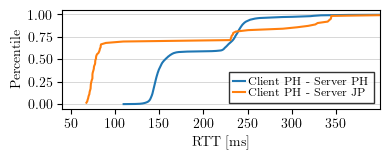

In [146]:
#def plot_cdf(df, cities, column, xlabel,

savefig=""
title="CDF"
city_colors={}
lstyles={}
condition=True
figures_path="figures"
xlim=None
legendsettings={}
legendloc="lower right"

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 1.7))

# Philippines->PH
xs = ph_df[ph_df["server_Geo_CountryCode"] == "PH"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="Client PH - Server PH")

# Philippines->PH
xs = ph_df[ph_df["server_Geo_CountryCode"] == "JP"]["a_MinRTT"].values
xs = sorted(xs)
if len(xs) == 0:
    raise RuntimeError()
ys = np.arange(1, len(xs) + 1) / len(xs)
indices = []
current = xs[0]
for i, x in enumerate(xs): # only take max y value at each x value to smoothen out the graph
    if x != current:
        current = x
        indices.append(i - 1)
indices.append(len(ys) - 1)
xs = sorted(set(xs))
ys = [ys[i] for i in indices]
ax.plot(xs, ys, label="Client PH - Server JP")

ax.set_xlim((40, 400))
ax.set_xlabel("RTT [ms]")
ax.set_ylabel("Percentile")
ax.set_yticks(np.arange(0, 1.25, 0.25))
ax.set_xticks(np.arange(50, 400, 50))
ax.xaxis.get_major_formatter()._usetex = False
ax.yaxis.get_major_formatter()._usetex = False

ax.legend(loc=legendloc, fontsize="small", ncol=1, edgecolor="k", handlelength=1, labelspacing=0.06,
          columnspacing=0.5, handletextpad=0.3, fancybox=False)
plt.grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

#plt.title(title)
fig.tight_layout()
plt.savefig(os.path.join("figures", "mlab_cdf_rtt_phjp.pdf"), bbox_inches="tight", pad_inches=0)
plt.show()

### LossRate CDF of global cities in Starlink vs. MNO

In [238]:
df = pd.read_csv("data/mlab_cdf_cities_down.csv")
# Turn str of list into python list
df["lossrate_percentiles"] = df["lossrate_percentiles"].apply(eval)
df["minrtt_percentiles"] = df["minrtt_percentiles"].apply(eval)
df["down_queuedelay_percentiles"] = df["down_queuedelay_percentiles"].apply(eval)
samecity_df = df[df["ClientCountryCode"] == df["ServerCountryCode"]]
samecity_df = samecity_df[samecity_df["MeasurementCount"] > 1000]
#samecity_df = samecity_df[samecity_df[""] > 1000]

In [239]:
city_cc_df = samecity_df[samecity_df["Operator"] == "sl"][["ClientCity", "ClientCountryCode"]].drop_duplicates()
city_cc = [(row["ClientCity"], row["ClientCountryCode"]) for _, row in city_cc_df.iterrows()]

In [218]:
#city_cc = [
#        ("Mexico City", "MX"),
#        ("São Paulo", "BR"),
#        ("Seattle", "US"),
#        ("Sydney", "AU"),
#        ("Dublin", "IE"),
#        ("Lagos", "NG"),
#        ("Manila", "PH")
#]

#df = pd.read_csv("data/mlab_cdf_cities_down.csv")
# Turn str of list into python list
#df["lossrate_percentiles"] = df["lossrate_percentiles"].apply(eval)
#samecity_df = df[df["ClientCountryCode"] == df["ServerCountryCode"]]
for idx, (city, cc) in enumerate(city_cc):
    if idx == 0:
        index_filter = (samecity_df["ClientCity"] == city) & (samecity_df["ClientCountryCode"] == cc)
    else:
        index_filter = index_filter | (samecity_df["ClientCity"] == city) & (samecity_df["ClientCountryCode"] == cc)

samecity_df = samecity_df[index_filter]

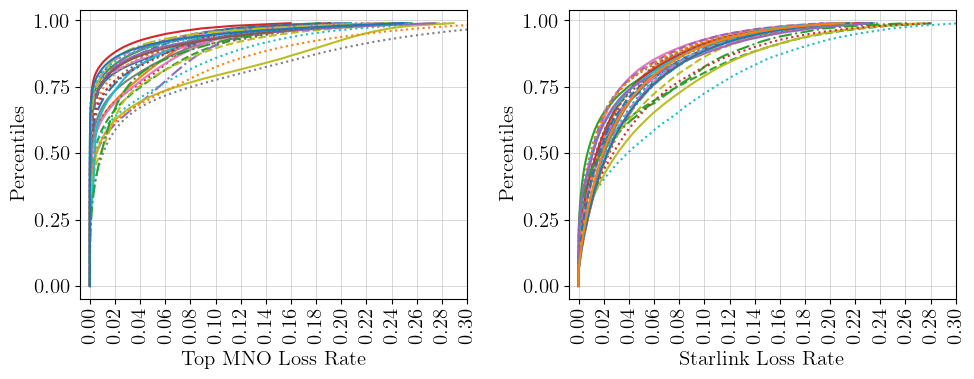

In [230]:
rcParams["font.family"] = "CMU Sans Serif"
# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)
plt.rcParams['image.cmap'] = 'tab10'

#fig, ax = plt.subplots(figsize=(3.37, 2))

matplotlib.rcParams.update({"font.size": 15})
fig, axs = plt.subplots(figsize=(10, 4.04), ncols=2)

data = df.to_dict("records")
ys = [v / 100 for v in range(100)]

lstyles_array = ["solid", "solid", "dashed", "dotted", "dashdot", "dotted"]

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "topmno"):
        continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    #axs[1].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    axs[1].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "sl"):
        continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    axs[0].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1
    
axs[0].xaxis.set_tick_params(rotation=90)
axs[1].xaxis.set_tick_params(rotation=90)
    
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
#if xlim:
#    axs[0].set_xlim(0, xlim)
axs[0].set_ylabel("Percentiles")
axs[0].set_xlabel("Top MNO Loss Rate")
axs[1].set_ylabel("Percentiles")
axs[1].set_xlabel("Starlink Loss Rate")
#if title:
#    axs[0].set_title(title)
#axs[0].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
#axs[1].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
axs[0].set_xticks(np.arange(0, 0.4, 0.02))
axs[1].set_xticks(np.arange(0, 0.4, 0.02))
axs[1].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)
axs[1].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].set_xlim((-0.008, 0.3))
axs[1].set_xlim((-0.008, 0.3))

fig.tight_layout()
#if args.save:
#    plt.savefig(args.save, bbox_inches="tight", pad_inches=0)
#else:
plt.show()


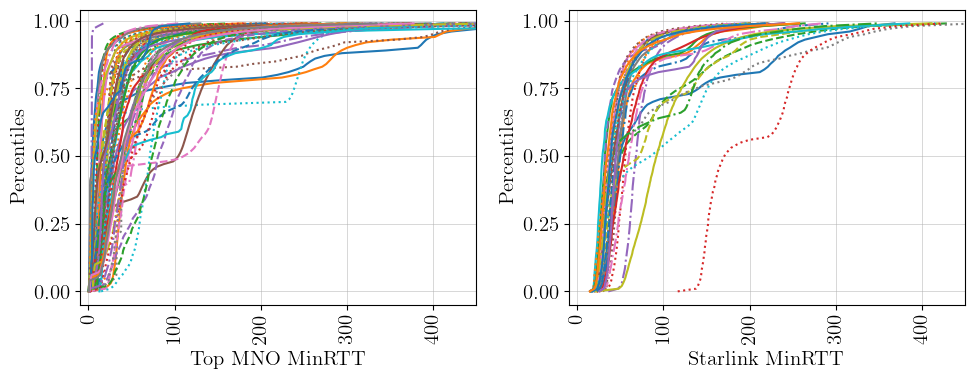

In [255]:
rcParams["font.family"] = "CMU Sans Serif"
# This will compile plots to be Latex compatible
plt.rc('text', usetex=True)
plt.rcParams['image.cmap'] = 'tab10'

#fig, ax = plt.subplots(figsize=(3.37, 2))

matplotlib.rcParams.update({"font.size": 15})
fig, axs = plt.subplots(figsize=(10, 4.04), ncols=2)

data = df.to_dict("records")
ys = [v / 100 for v in range(100)]

lstyles_array = ["solid", "solid", "dashed", "dotted", "dashdot", "dotted"]

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "topmno"):
        continue
    #if row["ClientCity"] == "Manila":
    #    continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    #axs[1].plot(row["lossrate_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    #axs[1].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)], color=plt.get_cmap("tab10").colors[0])
    axs[1].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1

i = 0
for idx, row in samecity_df.iterrows():
    if(row["Operator"] == "other"):
        continue
    elif(row["Operator"] == "sl"):
        continue
    label = "-".join([row["ClientCity"], row["Operator"]])
    #axs[0].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)], color=plt.get_cmap("tab10").colors[1])
    axs[0].plot(row["minrtt_percentiles"][:-1], ys, label=label, linestyle=lstyles_array[i % len(lstyles_array)])
    i += 1
    
axs[0].xaxis.set_tick_params(rotation=90)
axs[1].xaxis.set_tick_params(rotation=90)
    
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[0].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
axs[1].set_yticks([0, 0.25, 0.5, 0.75, 1])
#if xlim:
#    axs[0].set_xlim(0, xlim)
axs[0].set_ylabel("Percentiles")
axs[0].set_xlabel("Top MNO MinRTT")
axs[1].set_ylabel("Percentiles")
axs[1].set_xlabel("Starlink MinRTT")
#if title:
#    axs[0].set_title(title)
#axs[0].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
axs[0].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)
#axs[1].legend(loc="lower right", fontsize="small", ncol=2, edgecolor="k", handlelength=1, labelspacing=0.06,
#          columnspacing=0.5, handletextpad=0.3, fancybox=False)
#axs[0].set_xticks(np.arange(0, 0.4, 0.02))
#axs[1].set_xticks(np.arange(0, 0.4, 0.02))
axs[1].grid(True, axis='y', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)
axs[1].grid(True, axis='x', linestyle='-', alpha=0.7, linewidth=0.5)

axs[0].set_xlim((-10.0, 450))
axs[1].set_xlim((-10.0, 450))

fig.tight_layout()
#if args.save:
#    plt.savefig(args.save, bbox_inches="tight", pad_inches=0)
#else:
plt.show()


In [256]:
samecity_df[samecity_df["ClientCity"] == "Manila"]

,ClientCity,Operator,ClientCountryCode,ServerCountryCode,down_queuedelay_percentiles,lossrate_percentiles,minrtt_percentiles,MeasurementCount
316,Manila,sl,PH,PH,"[0.094, 9.552, 13.328, 16.315, 18.866, 21.628,...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.05850103...","[116.583, 137.849, 140.008, 141.241, 142.462, ...",13031
320,Manila,topmno,PH,PH,"[0.001, 4.695, 8.344, 12.978, 18.994, 25.954, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 4.578, 5.594, 6.545, 7.681, 8.686, 9.654...",557946
324,Manila,other,PH,PH,"[0.001, 0.571, 1.163, 1.853, 2.598, 3.499, 4.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.134, 0.989, 1.589, 2.02, 2.493, 2.813, 2.97...",3893669
356,Manila,other,US,US,"[0.084, 1.435, 2.741, 4.397, 5.18, 6.395, 7.66...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[6.564, 13.273, 14.732, 15.635, 16.676, 17.575...",2611


## Heatmap

In [257]:
#cell_filtered_perf_df = pd.read_csv("data/mlab_mnofiltered_country_agg.csv")
#cell_filtered_perf_df.set_index("CountryName", inplace=True)
cell_all_perf_down_df = pd.read_csv("data/mlab_mno_down_country_agg.csv")
cell_all_perf_up_df = pd.read_csv("data/mlab_mno_up_country_agg.csv")

#cell_all_perf_df.set_index("CountryName", inplace=True)
country_perf_down_df = pd.read_csv("data/mlab_starlink_down_country_agg.csv")
country_perf_down_df.set_index("CountryName", inplace=True)
country_perf_up_df = pd.read_csv("data/mlab_starlink_up_country_agg.csv")
country_perf_up_df.set_index("CountryName", inplace=True)
#country_perf_df.set_index("CountryName", inplace=True)


country_agg_topmno_df = pd.read_csv("data/mlab_mno_country_agg.csv")
country_agg_sl_df = pd.read_csv("data/mlab_starlink_country_agg.csv")

In [258]:
import pycountry
import re
import geopandas
import cartopy
import cartopy.crs as ccrs
from matplotlib import colors
from matplotlib.lines import Line2D

countries_name2code = {}
for country in pycountry.countries:
    if re.search("moldova", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "Moldova"
    elif re.search("saint martin", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "Saint Martin"
    elif re.search("Virgin Islands, U.S.", country.name, re.IGNORECASE):
        #print(country.name)
        countryname = "U.S. Virgin Islands"
    else:
        countryname = country.name
    countries_name2code[countryname] = country.alpha_2


In [259]:
import json
# Country Codes
with open("data/iso3.json", mode="r", encoding="utf-8") as file:
    f = json.load(file)
country_codes = {value: key for key, value in f.items()} # create mapping from 2-letter to 3-letter country code

In [244]:
joined_country_perf_df = country_perf_up_df.join(country_perf_down_df, lsuffix="_up", rsuffix="_down")

In [245]:
joined_country_perf_df

,avg_latitude_up,avg_longitude_up,avg_minrtt_up,median_minrtt_up,avg_meanthroughputmbps_up,avg_lossraate_up,MostRecentTestTime_up,LeastRecentTestTime_up,TestSpanDays_up,count_measurements_up,avg_latitude_down,avg_longitude_down,avg_minrtt_down,median_minrtt_down,avg_meanthroughputmbps_down,avg_lossraate_down,MostRecentTestTime_down,LeastRecentTestTime_down,TestSpanDays_down,count_measurements_down
CountryName,,,,,,,,,,,,,,,,,,,,
Brazil,-23.533500,-46.635900,929.176755,46.0050,7.253120,0.0,2023-04-30 23:59:00.104042 UTC,2021-12-12 22:37:08.453848 UTC,504,111763,-23.533500,-46.635900,415.769100,43.8810,46.306738,0.053757,2023-04-30 23:58:47.150704 UTC,2021-12-12 22:36:56.948501 UTC,504,141327
Sweden,59.328700,18.071700,87.528339,62.8720,6.795006,0.0,2023-04-30 18:35:09.443552 UTC,2022-04-10 16:59:26.762252 UTC,385,375,59.328700,18.071700,82.983876,61.8640,63.898157,0.043852,2023-04-30 20:02:20.165821 UTC,2022-04-10 16:59:16.082596 UTC,385,517
Mexico,19.432600,-99.133200,1482.761557,84.6820,4.217247,0.0,2023-04-30 23:59:34.283091 UTC,2022-02-24 05:21:26.626759 UTC,430,167595,19.432600,-99.133200,639.363323,82.2270,34.787560,0.058084,2023-04-30 23:59:23.634286 UTC,2022-02-24 05:21:15.201773 UTC,430,213031
Norway,59.865684,10.797534,70.308172,61.2190,7.264885,0.0,2023-04-30 19:35:44.307053 UTC,2022-09-02 12:00:26.564360 UTC,240,658,59.865731,10.797567,68.407346,59.3400,66.726527,0.034855,2023-04-30 21:10:12.608472 UTC,2022-09-02 12:00:15.848524 UTC,240,772
Peru,-12.043534,-77.029723,75.954649,36.3800,8.315663,0.0,2023-04-30 23:14:18.963190 UTC,2022-12-22 15:28:56.355826 UTC,129,3969,-12.043530,-77.029705,73.947152,32.9160,51.634645,0.049067,2023-04-30 23:14:07.342790 UTC,2022-12-22 15:28:44.049524 UTC,129,4550
Greece,37.984200,23.735300,94.180073,92.2430,6.160866,0.0,2023-04-29 19:36:16.727188 UTC,2022-05-30 17:01:50.593773 UTC,334,82,37.984200,23.735300,93.586578,93.2280,76.358484,0.038475,2023-04-29 19:36:03.555762 UTC,2022-05-30 17:01:39.214631 UTC,334,225
Slovenia,46.051525,14.512213,66.685375,62.6805,15.719304,0.0,2022-11-05 09:31:52.832821 UTC,2022-09-04 10:25:30.101508 UTC,61,8,46.051583,14.512575,59.574083,57.4240,44.663797,0.144958,2023-02-06 18:18:35.924965 UTC,2022-09-14 09:08:58.101869 UTC,145,12
Spain,40.416300,-3.693400,266.821464,30.9895,11.002080,0.0,2023-04-30 23:58:03.523358 UTC,2022-04-02 05:54:16.845475 UTC,393,19532,40.416300,-3.693400,360.208547,29.2960,80.342755,0.030466,2023-04-30 23:57:52.164566 UTC,2022-04-02 05:54:04.823300 UTC,393,27242
Nigeria,6.447400,3.390300,493.306903,27.9560,7.200747,0.0,2023-04-30 23:43:56.919349 UTC,2022-11-19 17:40:30.508795 UTC,162,9617,6.447400,3.390300,829.101652,25.4955,55.613179,0.032585,2023-04-30 23:43:44.004199 UTC,2022-11-19 17:40:19.674106 UTC,162,10964


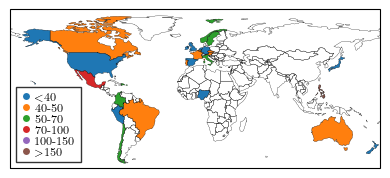

In [273]:
### Generating Example Data
used_df = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 500].reset_index()
used_df = used_df[used_df["CountryName"].isin(countries)]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

matplotlib.rcParams.update({"font.size": 10})
fig, ax = plt.subplots(figsize=(4, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150, 99999999]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig("figures/mlab_mapped_medianminrtt_oneyear_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/mlab_mapped_medianminrtt_oneyear_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

           CountryName  median_minrtt
25         Netherlands          8.514
22         New Zealand          9.220
3              Ireland         12.321
20      United Kingdom         13.000
19              France         13.032
14             Belgium         15.059
4                Spain         17.138
2               Norway         17.672
24              Canada         17.677
11             Germany         18.063
15            Portugal         19.575
10             Nigeria         23.000
21               Italy         23.839
7                Japan         26.941
8            Australia         27.865
18               Chile         28.282
9              Austria         29.247
5               Brazil         33.852
17         Philippines         35.696
1                 Peru         36.742
23       United States         39.489
13         Puerto Rico         44.988
26  Dominican Republic         54.393
6               Mexico         84.000
12            Colombia         91.941


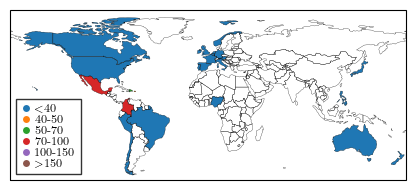

In [274]:
### Generating Example Data
used_df = country_agg_topmno_df[country_agg_topmno_df["count_measurements"] > 500]
used_df = used_df[used_df["CountryName"].isin(countries)]
used_df = used_df[~used_df["CountryName"].isin(["Martinique", "Saint Barthélemy"])]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

print(used_df[["CountryName", "median_minrtt"]].sort_values("median_minrtt"))

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150, 99999999]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
# The bins have been manually editted, ....
plt.savefig("figures/mlab_mnocell-all_mapped_medianminrtt_oneyear_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.savefig("figures/mlab_mnocell-all_mapped_medianminrtt_oneyear_heatmap.svg", bbox_inches="tight", pad_inches=0)
plt.show()

In [272]:
country_agg_topmno_df.rename(columns={country_agg_topmno_df.columns[1]:"CountryCode"})
country_agg_sl_df.rename(columns={country_agg_sl_df.columns[1]:"CountryCode"})

,CountryName,CountryCode,avg_latitude,avg_longitude,avg_minrtt,median_minrtt,avg_meanthroughputmbps,avg_lossraate,MostRecentTestTime,LeastRecentTestTime,TestSpanDays,count_measurements
0,Peru,PE,-12.043532,-77.029713,74.593492,34.4560,31.330975,0.026105,2023-04-30 23:14:18.963190 UTC,2022-12-22 15:28:44.049524 UTC,129,8552
1,Norway,NO,59.865766,10.797590,69.040591,60.0050,39.228692,0.018751,2023-04-30 21:10:12.608472 UTC,2022-09-02 12:00:15.848524 UTC,240,1435
2,Netherlands,NL,52.375148,4.895891,45.877564,39.8125,42.396782,0.021206,2023-04-30 18:08:35.966083 UTC,2022-03-17 11:08:32.356560 UTC,409,9702
3,Dominican Republic,DO,18.462905,-69.892366,70.202859,65.4680,30.167495,0.030419,2023-04-30 23:37:38.238404 UTC,2022-08-14 01:50:30.778199 UTC,259,6977
4,Kenya,KE,-1.284100,36.815500,407.086000,390.6765,9.678349,0.011255,2023-04-27 08:39:21.917867 UTC,2023-04-17 09:58:15.225784 UTC,9,6
5,Canada,CA,46.114801,-91.912607,382.062358,47.9770,35.435985,0.021803,2023-04-30 23:59:35.049282 UTC,2021-09-19 04:07:02.760988 UTC,588,1665647
6,Philippines,PH,14.601900,120.989600,190.765655,157.3240,18.327661,0.027587,2023-04-30 23:51:59.392923 UTC,2022-12-07 05:01:34.287516 UTC,144,25698
7,Chile,CL,-33.451460,-70.662967,714.877629,56.8810,30.891460,0.024338,2023-04-30 23:29:49.560796 UTC,2022-03-17 04:18:35.540836 UTC,409,75182
8,Mozambique,MZ,-25.970700,32.601000,427.064182,436.2200,8.157041,0.018660,2023-04-06 16:51:57.972990 UTC,2022-11-07 16:08:17.713719 UTC,150,33
9,Ireland,IE,53.337950,-6.259100,293.059330,39.3740,46.838466,0.020197,2023-04-30 23:59:20.927747 UTC,2022-02-18 01:34:38.985168 UTC,436,68964


In [116]:
mapclassify.UserDefined(used_df["median_minrtt"], bins=[40,50,70,100,150, 100000])

UserDefined

    Interval       Count
------------------------
[  8.48,  40.00] |    21
( 40.00,  50.00] |     1
( 50.00,  70.00] |     1
( 70.00, 100.00] |     2
(100.00, 150.00] |     0

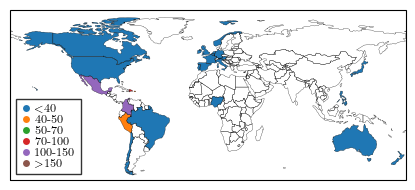

In [55]:
### Generating Example Data
used_df = cell_filtered_perf_df[cell_filtered_perf_df["count_measurements"] > 1000]
used_df = used_df[used_df["CountryName"].isin(countries)]
example_country_data = {countries_name2code[row["CountryName"]]: row["median_minrtt"]  for _, row in used_df.iterrows()}

### Plotting Example Data in Map

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world = world[(world.name!="Antarctica")] # remove Antarctica
    
country_data = []
for name, code in zip(world["name"], world["iso_a3"]):    
    if name == "France":
        country_data.append(example_country_data[country_codes["FRA"]])
    elif name == "Norway":
        country_data.append(example_country_data[country_codes["NOR"]])
    elif code in country_codes and country_codes[code] in example_country_data:
        country_data.append(example_country_data[country_codes[code]])
    else:
        country_data.append(float("NaN"))
world["data"] = country_data

fig, ax = plt.subplots(figsize=(4.66, 2), subplot_kw={'projection': ccrs.PlateCarree()})

labels = ["$<$40", "40-50", "50-70", "70-100", "100-150", "$>$150"]
cmap = "tab10"
cols = plt.get_cmap("tab10").colors[:6]
cmap = colors.ListedColormap(cols)
handles = [Line2D([0], [0], marker="o", color="w", markerfacecolor=col)
           for col in cols]
ax.legend(handles, labels, handlelength=1, labelspacing=0.06, columnspacing=0.5, handletextpad=0.3,
          loc="lower left", fancybox=False, edgecolor="k", fontsize="small")

world.plot(facecolor ="#00000000", ax=ax, edgecolor="black", linewidth=0.2)
world.plot(column="data", cmap=cmap, scheme='UserDefined', 
           classification_kwds=dict(bins=[40,50,70,100, 150]), zorder=0, ax=ax)
ax.set_extent([-180, 180, -60, 90], ccrs.PlateCarree())
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

fig.tight_layout()
plt.savefig("figures/mlab_mnocell-filtered_mapped_medianminrtt_oneyear_heatmap.pdf", bbox_inches="tight", pad_inches=0)
plt.show()

In [89]:
print("(\n{} \n)".format(" OR\n".join(["\tclient.Geo.CountryName = \"{}\"".format(countryname) for countryname in used_df["CountryName"]])))

(
	client.Geo.CountryName = "Portugal" OR
	client.Geo.CountryName = "Ireland" OR
	client.Geo.CountryName = "France" OR
	client.Geo.CountryName = "United Kingdom" OR
	client.Geo.CountryName = "Belgium" OR
	client.Geo.CountryName = "Nigeria" OR
	client.Geo.CountryName = "Austria" OR
	client.Geo.CountryName = "Netherlands" OR
	client.Geo.CountryName = "Dominican Republic" OR
	client.Geo.CountryName = "Canada" OR
	client.Geo.CountryName = "United States" OR
	client.Geo.CountryName = "Italy" OR
	client.Geo.CountryName = "New Zealand" OR
	client.Geo.CountryName = "Germany" OR
	client.Geo.CountryName = "Chile" OR
	client.Geo.CountryName = "Philippines" OR
	client.Geo.CountryName = "Brazil" OR
	client.Geo.CountryName = "Colombia" OR
	client.Geo.CountryName = "Puerto Rico" OR
	client.Geo.CountryName = "Mexico" OR
	client.Geo.CountryName = "Spain" OR
	client.Geo.CountryName = "Peru" OR
	client.Geo.CountryName = "Norway" OR
	client.Geo.CountryName = "Australia" OR
	client.Geo.CountryName = "Japan

In [90]:
import math
for n, d in zip(world["name"], world["data"]):  
    if math.isnan(d):
        continue
    print(n, d)

Canada 16.431
United States of America 38.432
Chile 33.105
Dominican Rep. 56.1995
Norway 18.081
Mexico 78.499
Brazil 37.117
Peru 46.2
Colombia 89.718
France 20.24
Puerto Rico 45.16
Nigeria 26.177
Austria 28.792
Germany 19.32
Belgium 15.9605
Netherlands 10.383
Portugal 19.614
Spain 23.0
Ireland 9.888
New Zealand 12.201
Australia 24.08
Italy 24.19
United Kingdom 16.504
Philippines 37.4175
Japan 29.753


In [476]:
buckets = [40, 50, 70, 100, 150, 999999]

last_limit = 0
for i in range(len(buckets)):
    print("..............")
    print("{}<{}".format(last_limit, buckets[i]))
    print(len(used_df[(used_df["median_minrtt"] > last_limit) & (used_df["median_minrtt"] < buckets[i])]))
    print("..............")
    last_limit = buckets[i]

..............
0<40
10
..............
..............
40<50
8
..............
..............
50<70
7
..............
..............
70<100
1
..............
..............
100<150
3
..............
..............
150<999999
1
..............


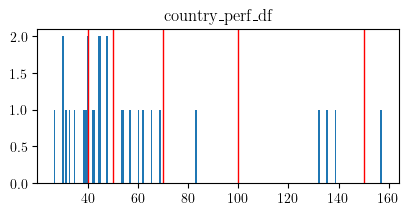

In [474]:
fig, ax = plt.subplots(figsize=(4.66, 2))
used_df = country_agg_sl_df[country_agg_sl_df["count_measurements"] > 500]
used_df = used_df[used_df["CountryName"].isin(countries)]
ax.set_title("country_perf_df")
ax.hist(used_df["median_minrtt"], bins=200)
ax.axvline(40, color="r", linewidth="1.0")
ax.axvline(50, color="r", linewidth="1.0")
ax.axvline(70, color="r", linewidth="1.0")
ax.axvline(100, color="r", linewidth="1.0")
ax.axvline(150, color="r", linewidth="1.0")

#ax.axvline(1000, color="r", linewidth="1.0")
#ax.axvline(1800, color="r", linewidth="1.0")
#ax.set_xticks(range(0, 1000, 100))
plt.show()

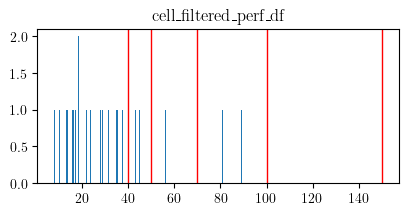

In [57]:
fig, ax = plt.subplots(figsize=(4.66, 2))
used_df = cell_filtered_perf_df[cell_filtered_perf_df["count_measurements"] > 1000]
used_df = used_df[used_df["CountryName"].isin(countries)]
ax.set_title("cell_filtered_perf_df")
ax.hist(used_df["median_minrtt"], bins=200)
ax.axvline(40, color="r", linewidth="1.0")
ax.axvline(50, color="r", linewidth="1.0")
ax.axvline(70, color="r", linewidth="1.0")
ax.axvline(100, color="r", linewidth="1.0")
ax.axvline(150, color="r", linewidth="1.0")

#ax.axvline(1000, color="r", linewidth="1.0")
#ax.axvline(1800, color="r", linewidth="1.0")
#ax.set_xticks(range(0, 1000, 100))
plt.show()

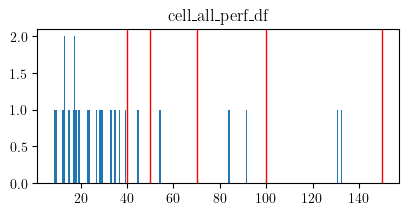

In [58]:
fig, ax = plt.subplots(figsize=(4.66, 2))
used_df = cell_all_perf_df[cell_all_perf_df["count_measurements"] > 1000]
used_df = used_df[used_df["CountryName"].isin(countries)]
ax.set_title("cell_all_perf_df")
ax.hist(used_df["median_minrtt"], bins=200)
ax.axvline(40, color="r", linewidth="1.0")
ax.axvline(50, color="r", linewidth="1.0")
ax.axvline(70, color="r", linewidth="1.0")
ax.axvline(100, color="r", linewidth="1.0")
ax.axvline(150, color="r", linewidth="1.0")

#ax.axvline(1000, color="r", linewidth="1.0")
#ax.axvline(1800, color="r", linewidth="1.0")
#ax.set_xticks(range(0, 1000, 100))
plt.show()

In [80]:
cell_all_perf_df[cell_all_perf_df["median_minrtt"] > 120]

,CountryName,avg_latitude,avg_longitude,avg_minrtt,median_minrtt,avg_meanthroughputmbps,avg_lossraate,MostRecentTestTime,LeastRecentTestTime,TestSpanDays,count_measurements
0,Saint Barthélemy,17.883335,-62.849921,144.934831,132.841,32.154885,0.043679,2023-03-26 02:48:20.670685 UTC,2022-05-03 01:16:38.827560 UTC,327,2299
26,Martinique,14.625366,-61.049961,2171.200512,130.938,10.158154,0.025815,2023-04-30 22:10:58.509910 UTC,2022-05-10 13:54:50.791255 UTC,355,8493


In [ ]:
used_df[used_df["avg_minrtt"] > 500]

In [64]:
joined_all_df = cell_all_perf_df.set_index("CountryName").join(country_perf_df.set_index("CountryName"), lsuffix="_cellall", rsuffix="_sl")
joined_all_df["median_minrtt_diff"] = joined_all_df["median_minrtt_cellall"] - joined_all_df["median_minrtt_sl"]

In [93]:
joined_all_df[["median_minrtt_cellall", "median_minrtt_sl", "median_minrtt_diff"]].sort_values("median_minrtt_diff")

,median_minrtt_cellall,median_minrtt_sl,median_minrtt_diff
CountryName,,,
Philippines,35.123,157.3240,-122.2010
Norway,17.639,60.0050,-42.3660
France,13.016,47.9845,-34.9685
Netherlands,8.482,39.8125,-31.3305
Italy,23.836,54.3320,-30.4960
Canada,17.670,47.9770,-30.3070
Belgium,15.077,44.6365,-29.5595
Chile,28.314,56.8810,-28.5670
Ireland,12.297,39.3740,-27.0770


In [65]:
joined_all_df

,avg_latitude_cellall,avg_longitude_cellall,avg_minrtt_cellall,median_minrtt_cellall,avg_meanthroughputmbps_cellall,avg_lossraate_cellall,MostRecentTestTime_cellall,LeastRecentTestTime_cellall,TestSpanDays_cellall,count_measurements_cellall,...,avg_longitude_sl,avg_minrtt_sl,median_minrtt_sl,avg_meanthroughputmbps_sl,avg_lossraate_sl,MostRecentTestTime_sl,LeastRecentTestTime_sl,TestSpanDays_sl,count_measurements_sl,median_minrtt_diff
CountryName,,,,,,,,,,,,,,,,,,,,,
Saint Barthélemy,17.883335,-62.849921,144.934831,132.841,32.154885,0.043679,2023-03-26 02:48:20.670685 UTC,2022-05-03 01:16:38.827560 UTC,327,2299,...,-62.850000,133.512429,131.8315,26.671674,0.044760,2023-04-30 13:04:47.689881 UTC,2022-08-13 03:41:17.271398 UTC,260,1558,1.0095
Mexico,20.436227,-99.793593,1091.911024,84.322,11.745174,0.055059,2023-04-30 23:59:40.828185 UTC,2022-05-01 23:46:13.012151 UTC,364,1892835,...,-99.133200,1005.495566,83.0710,21.216707,0.032341,2023-04-30 23:59:34.283091 UTC,2022-02-24 05:21:15.201773 UTC,430,382605,1.2510
Ireland,53.221935,-6.888225,816.524549,12.297,48.349404,0.009683,2023-04-30 23:59:48.427305 UTC,2022-05-01 23:55:42.866018 UTC,364,5681164,...,-6.259100,293.059330,39.3740,46.838466,0.020197,2023-04-30 23:59:20.927747 UTC,2022-02-18 01:34:38.985168 UTC,436,68964,-27.0770
Australia,-33.605715,146.038576,1080.953732,28.652,29.917192,0.016750,2023-04-30 23:59:55.511838 UTC,2022-05-01 22:36:15.486759 UTC,364,20964255,...,151.072130,527.621396,42.6580,37.937865,0.021079,2023-04-30 23:58:56.603387 UTC,2022-03-11 05:03:05.982105 UTC,415,839872,-14.0060
United States,36.660346,-95.047641,253.535714,39.543,41.098903,0.012613,2023-04-30 23:59:54.406472 UTC,2022-05-01 23:17:34.297661 UTC,364,46951971,...,-98.929003,306.811187,32.8305,28.661264,0.022723,2023-04-30 23:59:39.783426 UTC,2021-06-30 02:29:10.036432 UTC,669,7636858,6.7125
Brazil,-21.822826,-46.312049,1467.686752,33.285,56.356244,0.021105,2023-04-30 23:59:46.861909 UTC,2022-05-01 23:30:48.643038 UTC,364,37928200,...,-46.635900,638.811771,44.5020,28.894670,0.029847,2023-04-30 23:59:00.104042 UTC,2021-12-12 22:36:56.948501 UTC,504,254546,-11.2170
Canada,45.513311,-86.997535,618.503057,17.670,116.084408,0.015022,2023-04-30 23:59:51.586191 UTC,2022-05-01 23:32:39.798390 UTC,364,25236154,...,-91.912607,382.062358,47.9770,35.435985,0.021803,2023-04-30 23:59:35.049282 UTC,2021-09-19 04:07:02.760988 UTC,588,1665647,-30.3070
Netherlands,52.232065,5.241082,310.511036,8.482,82.937914,0.017855,2023-04-30 23:59:16.753206 UTC,2022-05-01 22:14:07.565842 UTC,364,4271222,...,4.895891,45.877564,39.8125,42.396782,0.021206,2023-04-30 18:08:35.966083 UTC,2022-03-17 11:08:32.356560 UTC,409,9702,-31.3305
Dominican Republic,18.612985,-69.952079,497.026792,54.207,15.463990,0.040954,2023-04-30 23:59:33.277624 UTC,2022-05-01 23:55:14.733181 UTC,364,119386,...,-69.892366,70.202859,65.4680,30.167495,0.030419,2023-04-30 23:37:38.238404 UTC,2022-08-14 01:50:30.778199 UTC,259,6977,-11.2610


In [68]:
joined_all_df[["median_minrtt_cellall", "median_minrtt_sl"]]

,median_minrtt_cellall,median_minrtt_sl
CountryName,,
Saint Barthélemy,132.841,131.8315
Mexico,84.322,83.0710
Ireland,12.297,39.3740
Australia,28.652,42.6580
United States,39.543,32.8305
Brazil,33.285,44.5020
Canada,17.670,47.9770
Netherlands,8.482,39.8125
Dominican Republic,54.207,65.4680


In [67]:
joined_all_df[["median_minrtt_diff"]].sort_values("median_minrtt_diff")

,median_minrtt_diff
CountryName,
Philippines,-122.2010
Norway,-42.3660
France,-34.9685
Netherlands,-31.3305
Italy,-30.4960
Canada,-30.3070
Belgium,-29.5595
Chile,-28.5670
Ireland,-27.0770


In [ ]:
slrank_df = pd.read_csv("data/mlab_country_starlinkrank.csv", sep="\t")
slrank_df

In [ ]:
import seaborn as sns
import numpy as np
import seaborn as sns
data = [1.5]*7 + [2.5]*2 + [3.5]*8 + [4.5]*3 + [5.5]*1 + [6.5]*8
sns.set_style('whitegrid')
sns.kdeplot(np.array(data), bw=0.5)


## Weather Report

- https://en.wikipedia.org/wiki/December_2022_North_American_winter_storm

- https://en.wikipedia.org/wiki/2022%E2%80%9323_North_American_winter

In [ ]:
# Dec 21-26 2022

# Sept 21-26  2022

# TBD
lat_bounds = ()
lon_bounds = ()

## Boxplots

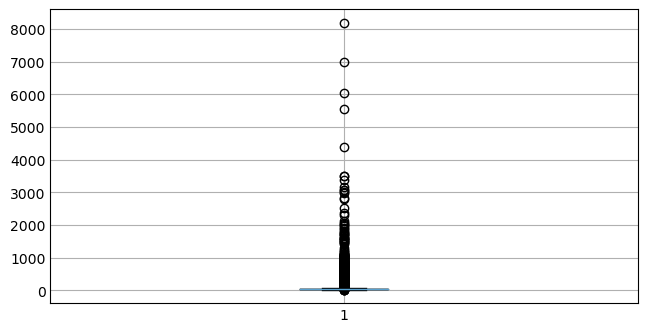

In [4]:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('_mpl-gallery')

# make data:
#np.random.seed(10)
#arr1 = np.random.normal(5, 1, size=(10,))
#arr2 = np.random.normal(3, 3, size=(10,))
#arr3 = np.random.normal(10, 0.3, size=(10,))
#arr4 = np.random.normal(4, 5, size=(10,))

#columns = [
#    df[df["ClientCity"] == "Mexico City"]["MinRTT"],
#    df[df["ClientCity"] == "Bogotá"]["MinRTT"],
#    df[df["ClientCity"] == "Oslo"]["MinRTT"],
#    df[df["ClientCity"] == "Seattle"]["MinRTT"],
#    df[df["ClientCity"] == "Sydney"]["MinRTT"]
#]

columns = [df[(df["ClientCity"] == "Berlin") & (df["MinRTT"] < 100000)]["MinRTT"]]

fig, ax = plt.subplots(figsize=(6, 3))
ax.boxplot(columns)
plt.show()

In [7]:
def row2box(row, attr, usestd = True):
    median = row["{}_q2".format(attr)]
    
    if(usestd):
        q0 = median - row["{}_stddev".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = median + row["{}_stddev".format(attr)]
    else:
        q0 = row["{}_q0".format(attr)]
        q0 = 0 if q0 < 0 else q0
        q4 = row["{}_q4".format(attr)]
        q4 = row["{}_q3".format(attr)]
    
    return {
        'label' : row.name,
        'whislo': q0,# Bottom whisker position
        'q1'    : row["{}_q1".format(attr)],             # First quartile (25th percentile)
        'med'   : median,                                # Median         (50th percentile)
        'q3'    : row["{}_q3".format(attr)],             # Third quartile (75th percentile)
        'whishi': q4,    # Top whisker position
        'fliers': []                                     # Outliers
    }

def visualize_boxplot(df, attr, save=False, usestd=True):
    fig, ax = plt.subplots(figsize=(6, 3))
    boxes = [row2box(row, attr, usestd=usestd) for idx, row in df.iterrows()]
    ax.bxp(boxes, showfliers=False)
    
    if(attr == "MeanThroughputMbps"):
        ax.set_ylabel("Mean Throughput in Mbps")
    elif(attr == "MinRTT"):
        ax.set_ylabel("Min RTT in milliseconds")
    elif(attr == "lossrate"):
        ax.set_ylabel("Lossrate from the lifetime of the connection")
    
    if(save):
        plt.tight_layout()
        plt.savefig("mlab_{}_starlink_boxplot.pdf".format(attr))
    plt.show()
    
    
# [x] Filter Edge-Cases:
    # MinRTT = -1
    # Meanthroughput = 0.0
    # lossrate = -1
# [ ] Inverstigate Max value, put those into outliers
    # Maximum values are probably better in a spearate plot
# TODO: [x] Use Standard Deviation instead of Maximum/Minimum
# [ ] Compare throughput latencies reported over Cellular Networks with the ones over Starlink
    # https://github.com/tkdang97/Cloudy-with-a-Chance-of-Short-RTTs/blob/main/speedchecker-analysis.ipynb
    # Associated Dataset
        # Compare ISPs by looking at probes that connect to the same endpoint
            # Throughput, Latency/RTT
        # Use above information to compare the ISP to Starlink
# [ ] Sync Throughput Count Map with availability
# 


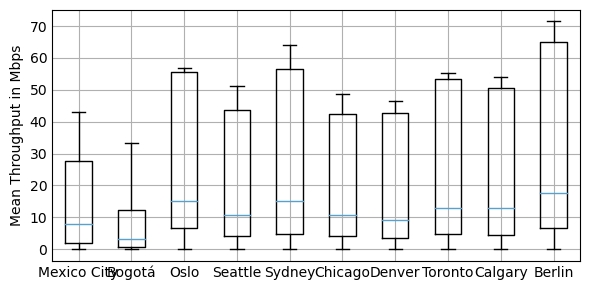

In [8]:
visualize_boxplot(df, "MeanThroughputMbps", save=True)

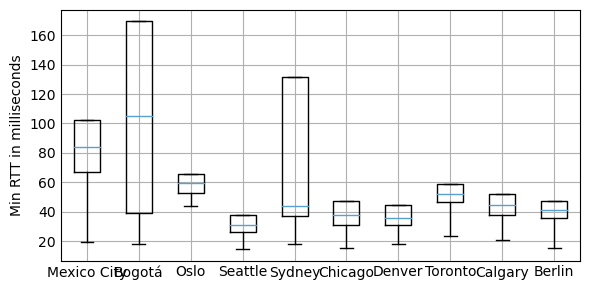

In [11]:
# This might be a bit interesting as CDF
#   - 75th percentile being lower than others 25th percentile
#   - long tail, from 75th percentile to max, there are interesting things going on

# Sydney vs. Seattle
#   - Satellite Density
#   - Gateway Distribution
#   - Groundstation Availability

# 2019 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

In [12]:
# 2019 - 2022
df["measurement_count"].sum()

3668876

In [13]:
# 2021 - 2022
df["measurement_count"].sum()

3668876

In [14]:
1483238 - 1467264

15974

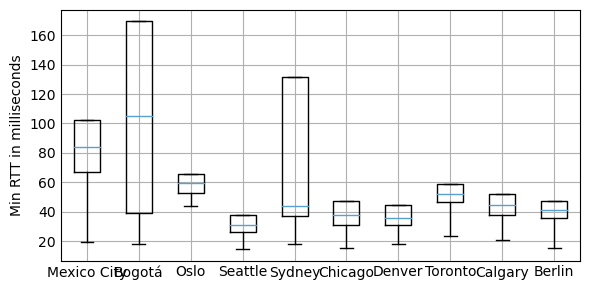

In [15]:
# 2021 - 2022
visualize_boxplot(df, "MinRTT", save=True, usestd=False)

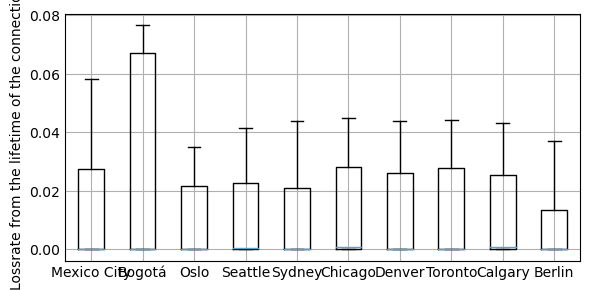

In [16]:
visualize_boxplot(df, "lossrate", save=True)